In [1]:
# We will look into two specialist models in this notebook. 

import torch
import torchvision 
import torchvision.transforms as transforms 
import torchvision.models as models 
import torch.optim as optim 
import torch.nn as nn 
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.colors

from collections import OrderedDict

In [2]:
def softmax(x, T=1):
    return np.exp(x/T)/sum(np.exp(x/T))

In [3]:
# Load and normalise data 
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

train_batch_size, test_batch_size = 128, 1024
trainset = torchvision.datasets.CIFAR100(root = './data', train = True, download = True, transform = transformation)
testset = torchvision.datasets.CIFAR100(root = './data', train = False, download = True, transform = transformation)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch_size, shuffle = False)

num_classes = 100

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
sub_classes = [[12, 13, 17, 23, 33, 37, 47, 49, 52, 56, 58, 59, 60, 68, 69, 71, 76, 85, 89, 90, 96], 
              [12, 17, 23, 33, 37, 47, 49, 52, 56, 59, 60, 68, 69, 71, 76, 81, 85, 90, 96]]

In [5]:
# Load generalist model (resnet-20) and 2 specialist models 
generalist_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained = False)
generalist_state_dict = torch.load("teacher_model_cifar100.pth")
generalist_model.load_state_dict(generalist_state_dict)
if torch.cuda.is_available(): 
    generalist_model = generalist_model.cuda() 
    
specialist_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained = False)
specialist_model.fc = nn.Linear(specialist_model.fc.in_features, len(sub_classes[0]) + 1)
specialist_state_dict = torch.load("specialist_0.pth")
specialist_model.load_state_dict(specialist_state_dict)
if torch.cuda.is_available(): 
    specialist_model = specialist_model.cuda() 
    
specialist_model_2 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained = False)
specialist_model_2.fc = nn.Linear(specialist_model_2.fc.in_features, len(sub_classes[1])+1)
specialist_state_dict_2 = torch.load("specialist_1.pth")
specialist_model_2.load_state_dict(specialist_state_dict_2)
if torch.cuda.is_available(): 
    specialist_model_2 = specialist_model_2.cuda() 

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/archive/master.zip" to /root/.cache/torch/hub/master.zip
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [6]:
def calculate_examples_called_by_specialists(generalist_model, specialist_model_1, specialist_model_2, testloader, sub_classes): 
    """ This function calculates the number of examples where: 
     
     generalist_model     specialist_model_1    specialist_model_2
          1                      1                     - 
          1                      0                     -
          0                      1                     - 
          0                      0                     -
          1                      -                     1
          1                      -                     0 
          0                      -                     1
          0                      -                     0 
          1                      1                     1
          1                      1                     0
          1                      0                     1
          1                      0                     0
          0                      1                     1
          0                      1                     0
          0                      0                     1
          0                      0                     0
    
    ** 1 means correct, 0 means wrong, and - means not applicable. 
    """
    
    
    generalist_model.eval() 
    specialist_model_1.eval() 
    specialist_model_2.eval()
        
    generalist_correct, generalist_wrong = 0, 0 
    s_called_total, g_correct_s1_correct, g_correct_s1_wrong, g_wrong_s1_correct, g_wrong_s1_wrong = 0, 0, 0, 0, 0
    g_correct_s2_correct, g_correct_s2_wrong, g_wrong_s2_correct, g_wrong_s2_wrong = 0, 0, 0, 0
    g_correct_s1_correct_s2_correct, g_correct_s1_correct_s2_wrong, g_correct_s1_wrong_s2_correct, g_correct_s1_wrong_s2_wrong = 0, 0, 0, 0
    g_wrong_s1_correct_s2_correct, g_wrong_s1_correct_s2_wrong, g_wrong_s1_wrong_s2_correct, g_wrong_s1_wrong_s2_wrong = 0, 0, 0, 0
    dustbin_s = 0 
    
    for i, data in enumerate(testloader, 0): 
        inputs, labels = data
        if torch.cuda.is_available(): 
            inputs, labels = inputs.cuda(), labels.cuda() 
            
        outputs = generalist_model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        specialist_outputs = specialist_model_1(inputs)
        _, specialist_preds = torch.max(specialist_outputs.data, 1)
        
        specialist_outputs_2 = specialist_model_2(inputs)
        _, specialist_preds_2 = torch.max(specialist_outputs_2.data, 1)
        
        num_examples_per_batch = labels.shape[0]
        for index in range(num_examples_per_batch): 
            pred, label = preds[index], labels[index]
            
            # If baseline predicted class belongs to subset of both specialists
            if pred in sub_classes[0] and pred in sub_classes[1]: 
                s_called_total += 1 
                
                if specialist_preds[index] != len(sub_classes[0]) and specialist_preds_2[index] != len(sub_classes[1]): 
                    sub_class = sub_classes[0]
                    sub_class_2 = sub_classes[1]
                    specialist_pred = sub_class[specialist_preds[index]]
                    specialist_pred_2 = sub_class_2[specialist_preds_2[index]]
                    if pred == label and specialist_pred == label and specialist_pred_2 == label: 
                        g_correct_s1_correct_s2_correct += 1
                    elif pred == label and specialist_pred == label and specialist_pred_2 != label: 
                        g_correct_s1_correct_s2_wrong += 1
                    elif pred == label and specialist_pred != label and specialist_pred_2 == label: 
                        g_correct_s1_wrong_s2_correct += 1                       
                    elif pred == label and specialist_pred != label and specialist_pred_2 != label: 
                        g_correct_s1_wrong_s2_wrong += 1
                    elif pred != label and specialist_pred == label and specialist_pred_2 == label: 
                        g_wrong_s1_correct_s2_correct += 1
                    elif pred != label and specialist_pred == label and specialist_pred_2 != label: 
                        g_wrong_s1_correct_s2_wrong += 1
                    elif pred != label and specialist_pred != label and specialist_pred_2 == label: 
                        g_wrong_s1_wrong_s2_correct += 1
                    elif pred != label and specialist_pred != label and specialist_pred_2 != label: 
                        g_wrong_s1_wrong_s2_wrong += 1
                else: 
                    dustbin_s += 1 
                    
            elif pred in sub_classes[0]: 
                s_called_total += 1 
                
                if specialist_preds[index] != len(sub_classes[0]): 
                    sub_class = sub_classes[0]
                    specialist_pred = sub_class[specialist_preds[index]]
                    if pred == label and specialist_pred == label: 
                        g_correct_s1_correct += 1 
                    elif pred == label and specialist_pred != label: 
                        g_correct_s1_wrong += 1 
                    elif pred != label and specialist_pred == label: 
                        g_wrong_s1_correct += 1 
                    elif pred != label and specialist_pred != label: 
                        g_wrong_s1_wrong += 1 
                else: 
                    if pred == label: 
                        generalist_correct += 1 
                    else: 
                        generalist_wrong += 1
            
            elif pred in sub_classes[1]: 
                s_called_total += 1 
                
                if specialist_preds_2[index] != len(sub_classes[1]): 
                    sub_class = sub_classes[1]
                    specialist_pred = sub_class[specialist_preds_2[index]]
                    if pred == label and specialist_pred == label: 
                        g_correct_s2_correct += 1 
                    elif pred == label and specialist_pred != label: 
                        g_correct_s2_wrong += 1 
                    elif pred != label and specialist_pred == label: 
                        g_wrong_s2_correct += 1 
                    elif pred != label and specialist_pred != label: 
                        g_wrong_s2_wrong += 1 
                else: 
                    if pred == label: 
                        generalist_correct += 1 
                    else: 
                        generalist_wrong += 1                               
            
                 
            # If baseline predicted class does not belong to subset of specialist and we only run generalist model: 
            else: 
                if pred == label: 
                    generalist_correct += 1 
                else: 
                    generalist_wrong += 1 
    
    
    stats = dict() 
    stats['generalist_correct'] = generalist_correct
    stats['generalist_wrong'] = generalist_wrong
    stats['s_called_total'] = s_called_total
    stats['g_correct_s1_correct'] = g_correct_s1_correct
    stats['g_correct_s1_wrong'] = g_correct_s1_wrong
    stats['g_wrong_s1_correct'] = g_wrong_s1_correct
    stats['g_wrong_s1_wrong'] = g_wrong_s1_wrong
    stats['g_correct_s2_correct'] = g_correct_s2_correct
    stats['g_correct_s2_wrong'] = g_correct_s2_wrong
    stats['g_wrong_s2_correct'] = g_wrong_s2_correct
    stats['g_wrong_s2_wrong'] = g_wrong_s2_wrong 
    stats['g_correct_s1_correct_s2_correct'] = g_correct_s1_correct_s2_correct
    stats['g_correct_s1_correct_s2_wrong'] = g_correct_s1_correct_s2_wrong
    stats['g_correct_s1_wrong_s2_correct'] = g_correct_s1_wrong_s2_correct
    stats['g_correct_s1_wrong_s2_wrong'] = g_correct_s1_wrong_s2_wrong
    stats['g_wrong_s1_correct_s2_correct'] = g_wrong_s1_correct_s2_correct
    stats['g_wrong_s1_correct_s2_wrong'] = g_wrong_s1_correct_s2_wrong
    stats['g_wrong_s1_wrong_s2_correct'] = g_wrong_s1_wrong_s2_correct
    stats['g_wrong_s1_wrong_s2_wrong'] = g_wrong_s1_wrong_s2_wrong
    stats['dustbin_s'] = dustbin_s
    
    return stats
    
    

In [7]:
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = False)
stats = calculate_examples_called_by_specialists(generalist_model, specialist_model, specialist_model_2, testloader, sub_classes)

print("Total number of examples where the specialist model is called: {}".format(stats['s_called_total']))
print("Generalist correct, specialist 1 correct: {} examples".format(stats['g_correct_s1_correct']))
print("Generalist correct, specialist 1 wrong: {} examples".format(stats['g_correct_s1_wrong']))
print("Generalist incorrect, specialist 1 correct: {} examples".format(stats['g_wrong_s1_correct']))
print("Generalist incorrect, specialist 1 incorrect: {} examples".format(stats['g_wrong_s1_wrong']))

print("Generalist correct, specialist 2 correct: {} examples".format(stats['g_correct_s2_correct']))
print("Generalist correct, specialist 2 wrong: {} examples".format(stats['g_correct_s2_wrong']))
print("Generalist incorrect, specialist 2 correct: {} examples".format(stats['g_wrong_s2_correct']))
print("Generalist incorrect, specialist 2 incorrect: {} examples".format(stats['g_wrong_s2_wrong']))

print("Generalist correct, specialist 1 correct, specialist 2 correct: {} examples".format(stats['g_correct_s1_correct_s2_correct']))
print("Generalist correct, specialist 1 wrong, specialist 2 correct: {} examples".format(stats['g_correct_s1_wrong_s2_correct']))
print("Generalist correct, specialist 1 correct, specialist 2 wrong: {} examples".format(stats['g_correct_s1_correct_s2_wrong']))
print("Generalist correct, specialist 1 wrong, specialist 2 wrong: {} examples".format(stats['g_correct_s1_wrong_s2_wrong']))

print("Generalist incorrect, specialist 1 correct, specialist 2 correct: {} examples".format(stats['g_wrong_s1_correct_s2_correct']))
print("Generalist incorrect, specialist 1 incorrect, specialist 2 correct: {} examples".format(stats['g_wrong_s1_wrong_s2_correct']))
print("Generalist incorrect, specialist 1 correct, specialist 2 wrong: {} examples".format(stats['g_wrong_s1_correct_s2_wrong']))
print("Generalist incorrect, specialist 1 incorrect, specialist 2 wrong: {} examples".format(stats['g_wrong_s1_wrong_s2_wrong']))
print("Number of examples predicted to be the dustbin class by any of the two specialists: {}".format(stats['dustbin_s']))

print("Generalist correct: {} examples".format(stats['generalist_correct']))
print("Generalist incorrect: {} examples".format(stats['generalist_wrong']))

Total number of examples where the specialist model is called: 2221
Generalist correct, specialist 1 correct: 70 examples
Generalist correct, specialist 1 wrong: 3 examples
Generalist incorrect, specialist 1 correct: 4 examples
Generalist incorrect, specialist 1 incorrect: 26 examples
Generalist correct, specialist 2 correct: 221 examples
Generalist correct, specialist 2 wrong: 7 examples
Generalist incorrect, specialist 2 correct: 7 examples
Generalist incorrect, specialist 2 incorrect: 47 examples
Generalist correct, specialist 1 correct, specialist 2 correct: 1262 examples
Generalist correct, specialist 1 wrong, specialist 2 correct: 41 examples
Generalist correct, specialist 1 correct, specialist 2 wrong: 32 examples
Generalist correct, specialist 1 wrong, specialist 2 wrong: 36 examples
Generalist incorrect, specialist 1 correct, specialist 2 correct: 34 examples
Generalist incorrect, specialist 1 incorrect, specialist 2 correct: 42 examples
Generalist incorrect, specialist 1 corr

In [8]:
total_corrects = stats['generalist_correct'] + stats['g_correct_s1_correct'] + stats['g_correct_s2_correct'] + stats['g_correct_s1_correct_s2_correct']
total_wrongs = stats['generalist_wrong'] + stats['g_wrong_s1_wrong'] + stats['g_wrong_s2_wrong'] + stats['g_wrong_s1_wrong_s2_wrong']
print("Number of examples that are definitely correct: {}".format(total_corrects))
print("Number of examples that are definitely wrong: {}".format(total_wrongs))
print("Number of examples that could be correctly or wrongly predicted by the iterative algorithm: {}".format(10000 - total_corrects - total_wrongs))

Number of examples that are definitely correct: 6775
Number of examples that are definitely wrong: 2968
Number of examples that could be correctly or wrongly predicted by the iterative algorithm: 257


In [9]:
def get_predicted_class_multiple(baseline_class, generalist_output, specialist_output, specialist_output_2, sub_classes): 
     
    """ This function runs the iterative algorithm by considering the generalist model and only two specialist models."""
    
    specialist_outputs = []
    specialist_outputs.append(specialist_output)
    specialist_outputs.append(specialist_output_2)
    
    num_classes = 100 
    q_dist = torch.randn(num_classes, requires_grad = True, device = "cuda:0")

    optimizer = optim.Adam([q_dist], lr = 0.01)
    criterion = nn.KLDivLoss() 
    previous_loss = 10000.0
    loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
    

    num_specialists = len(sub_classes)
    for i in range(num_specialists):
        sub_class = sub_classes[i]
        if baseline_class in sub_class: 
            modified_q_dist = np.zeros(len(sub_class) + 1)
            q_dist_copy = q_dist.clone() 
            for index in range(len(sub_class)): 
                modified_q_dist[index] = q_dist_copy[sub_class[index]]
                q_dist_copy[sub_class[index]] = 0.0 
                
            modified_q_dist[len(sub_class)] = torch.sum(q_dist_copy)
            modified_q_dist = torch.tensor(modified_q_dist)
            if torch.cuda.is_available(): 
                modified_q_dist = modified_q_dist.cuda()
                
            loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_outputs[i]))
            
        
    niter = 0
    history = OrderedDict()
    
    #while loss > 1e-3: 
    while previous_loss > loss and loss > 1e-3: 
        previous_loss = loss 
        loss.backward(retain_graph = True)
        optimizer.step()
        optimizer.zero_grad()
        loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
        
        for i in range(num_specialists): 
            sub_class = sub_classes[i]
            if baseline_class in sub_class: 
                modified_q_dist = np.zeros(len(sub_class) + 1)
                q_dist_copy = q_dist.clone() 
                for index in range(len(sub_class)): 
                    modified_q_dist[index] = q_dist_copy[sub_class[index]]
                    q_dist_copy[sub_class[index]] = 0.0 
                    
                modified_q_dist[len(sub_class)] = torch.sum(q_dist_copy)
                modified_q_dist = torch.tensor(modified_q_dist)
                if torch.cuda.is_available(): 
                    modified_q_dist = modified_q_dist.cuda()
                    
                loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_outputs[i]))
        
        niter+=1
        if niter % 50 == 0:
            #print("i: {:>4}, loss: {:.7f}".format(niter, loss))
            history[niter]=dict(logit=q_dist.detach().clone(), loss=loss.detach().clone())
            
    _, predicted = torch.max(q_dist.data, 0)
    return predicted, q_dist, history


def inspect_ensemble_predictions(generalist_model, specialist_model_1, specialist_model_2, testloader, sub_classes):
    """ 
    This function calculates: 
    (i) the number of examples that are correctly predicted by the iterative algorithm; 
    (ii) the number of examples that are wrongly predicted by the iterative algorithm; 
    
    It ignores examples with definitely correct and definitely wrong reference probability distributions. 
    It also considers the generalist model and only two specialist models. 
    """
  
    generalist_model.eval() 
    specialist_model_1.eval()
    specialist_model_2.eval() 
    
    g_correct_s1_wrong_e_correct, g_correct_s1_wrong_e_wrong, g_wrong_s1_correct_e_correct, g_wrong_s1_correct_e_wrong = 0, 0, 0, 0
    g_correct_s2_wrong_e_correct, g_correct_s2_wrong_e_wrong, g_wrong_s2_correct_e_correct, g_wrong_s2_correct_e_wrong = 0, 0, 0, 0
    g_correct_s1_correct_s2_wrong_e_correct, g_correct_s1_correct_s2_wrong_e_wrong = 0, 0 
    g_correct_s1_wrong_s2_correct_e_correct, g_correct_s1_wrong_s2_correct_e_wrong = 0, 0 
    g_correct_s1_wrong_s2_wrong_e_correct, g_correct_s1_wrong_s2_wrong_e_wrong = 0, 0 
    g_wrong_s1_correct_s2_correct_e_correct, g_wrong_s1_correct_s2_correct_e_wrong = 0, 0 
    g_wrong_s1_wrong_s2_correct_e_correct, g_wrong_s1_wrong_s2_correct_e_wrong = 0, 0 
    g_wrong_s1_correct_s2_wrong_e_correct, g_wrong_s1_correct_s2_wrong_e_wrong = 0, 0
    s_dustbin_e_correct, s_dustbin_e_wrong = 0, 0 
    
    indices = [] 
  
    for i, data in enumerate(testloader, 0): 
        inputs, labels = data 
        if torch.cuda.is_available(): 
            inputs, labels = inputs.cuda(), labels.cuda() 
            
        outputs = generalist_model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        specialist_outputs = specialist_model_1(inputs)
        _, specialist_preds = torch.max(specialist_outputs.data, 1)
        
        specialist_outputs_2 = specialist_model_2(inputs)
        _, specialist_preds_2 = torch.max(specialist_outputs_2.data, 1)
        
        num_examples_per_batch = labels.shape[0]
        for index in range(num_examples_per_batch): 
            pred, label = preds[index], labels[index]
            
            if pred in sub_classes[0] and pred in sub_classes[1]: 
                
                if specialist_preds[index] != len(sub_classes[0]) and specialist_preds_2[index] != len(sub_classes[1]): 
                    sub_class = sub_classes[0]
                    sub_class_2 = sub_classes[1]
                    specialist_pred = sub_class[specialist_preds[index]]
                    specialist_pred_2 = sub_class_2[specialist_preds_2[index]]
                    
                    if pred == label and specialist_pred == label and specialist_pred_2 != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred, 0])
                            g_correct_s1_correct_s2_wrong_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred, 1])
                            g_correct_s1_correct_s2_wrong_e_wrong += 1 
                    
                    elif pred == label and specialist_pred != label and specialist_pred_2 == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 2])
                            g_correct_s1_wrong_s2_correct_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 3])
                            g_correct_s1_wrong_s2_correct_e_wrong += 1                     
            

                    elif pred == label and specialist_pred != label and specialist_pred_2 != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 4])
                            g_correct_s1_wrong_s2_wrong_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 5])
                            g_correct_s1_wrong_s2_wrong_e_wrong += 1 
            
                    elif pred != label and specialist_pred == label and specialist_pred_2 != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 6])
                            g_wrong_s1_correct_s2_wrong_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 7])
                            g_wrong_s1_correct_s2_wrong_e_wrong += 1 
            

                    elif pred != label and specialist_pred != label and specialist_pred_2 == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred,8])
                            g_wrong_s1_wrong_s2_correct_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 9])
                            g_wrong_s1_wrong_s2_correct_e_wrong += 1 
                            
                    elif pred != label and specialist_pred == label and specialist_pred_2 == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 10])
                            g_wrong_s1_correct_s2_correct_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred,11])
                            g_wrong_s1_correct_s2_correct_e_wrong += 1 
                            
                else: 
                    ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                    if ensemble_pred == label: 
                        indices.append([i, index, label, pred, -1, -1, ensemble_pred,12])
                        s_dustbin_e_correct += 1 
                    else: 
                        indices.append([i, index, label, pred, -1, -1, ensemble_pred,13])
                        s_dustbin_e_wrong += 1
            
            elif pred in sub_classes[0]:  
                if specialist_preds[index] != len(sub_classes[0]):
                    sub_class = sub_classes[0]
                    specialist_pred = sub_class[specialist_preds[index]]
                    if pred == label and specialist_pred != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, -1,  ensemble_pred,14])
                            g_correct_s1_wrong_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, -1, ensemble_pred,15])
                            g_correct_s1_wrong_e_wrong += 1
                        
                    elif pred != label and specialist_pred == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index],sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, -1, ensemble_pred,16])
                            g_wrong_s1_correct_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, -1, ensemble_pred,17])
                            g_wrong_s1_correct_e_wrong += 1
                            
 
            elif pred in sub_classes[1]:  
                if specialist_preds_2[index] != len(sub_classes[1]):
                    sub_class = sub_classes[1]
                    specialist_pred = sub_class[specialist_preds_2[index]]
                    if pred == label and specialist_pred != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, -1, specialist_pred,  ensemble_pred,18])
                            g_correct_s2_wrong_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, -1, specialist_pred,ensemble_pred, 19])
                            g_correct_s2_wrong_e_wrong += 1
                        
                    elif pred != label and specialist_pred == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, -1, specialist_pred, ensemble_pred,20])
                            g_wrong_s2_correct_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, -1, specialist_pred,ensemble_pred, 21])
                            g_wrong_s2_correct_e_wrong += 1
                
                            
    stats = dict() 
    stats['g_correct_s1_wrong_e_correct'] = g_correct_s1_wrong_e_correct
    stats['g_correct_s1_wrong_e_wrong'] = g_correct_s1_wrong_e_wrong
    stats['g_wrong_s1_correct_e_correct'] = g_wrong_s1_correct_e_correct
    stats['g_wrong_s1_correct_e_wrong'] = g_wrong_s1_correct_e_wrong
    stats['g_correct_s2_wrong_e_correct'] = g_correct_s2_wrong_e_correct
    stats['g_correct_s2_wrong_e_wrong'] = g_correct_s2_wrong_e_wrong
    stats['g_wrong_s2_correct_e_correct'] = g_wrong_s2_correct_e_correct
    stats['g_wrong_s2_correct_e_wrong'] = g_wrong_s2_correct_e_wrong
    stats['g_correct_s1_wrong_s2_correct_e_correct'] = g_correct_s1_wrong_s2_correct_e_correct
    stats['g_correct_s1_wrong_s2_correct_e_wrong'] = g_correct_s1_wrong_s2_correct_e_wrong
    stats['g_correct_s1_correct_s2_wrong_e_correct'] = g_correct_s1_correct_s2_wrong_e_correct
    stats['g_correct_s1_correct_s2_wrong_e_wrong'] = g_correct_s1_correct_s2_wrong_e_wrong
    stats['g_correct_s1_wrong_s2_wrong_e_correct'] = g_correct_s1_wrong_s2_wrong_e_correct
    stats['g_correct_s1_wrong_s2_wrong_e_wrong'] = g_correct_s1_wrong_s2_wrong_e_wrong
    stats['g_wrong_s1_correct_s2_correct_e_correct'] = g_wrong_s1_correct_s2_correct_e_correct
    stats['g_wrong_s1_correct_s2_correct_e_wrong'] = g_wrong_s1_correct_s2_correct_e_wrong
    stats['g_wrong_s1_wrong_s2_correct_e_correct'] = g_wrong_s1_wrong_s2_correct_e_correct
    stats['g_wrong_s1_wrong_s2_correct_e_wrong'] = g_wrong_s1_wrong_s2_correct_e_wrong
    stats['g_wrong_s1_correct_s2_wrong_e_correct'] = g_wrong_s1_correct_s2_wrong_e_correct
    stats['g_wrong_s1_correct_s2_wrong_e_wrong'] = g_wrong_s1_correct_s2_wrong_e_wrong
    stats['s_dustbin_e_correct'] = s_dustbin_e_correct
    stats['s_dustbin_e_wrong'] = s_dustbin_e_wrong
    
    return indices, stats


In [10]:
indices, ensemble_stats = inspect_ensemble_predictions(generalist_model, specialist_model, specialist_model_2, testloader, sub_classes)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to i

In [11]:
ensemble_stats

{'g_correct_s1_wrong_e_correct': 1,
 'g_correct_s1_wrong_e_wrong': 2,
 'g_wrong_s1_correct_e_correct': 0,
 'g_wrong_s1_correct_e_wrong': 4,
 'g_correct_s2_wrong_e_correct': 3,
 'g_correct_s2_wrong_e_wrong': 4,
 'g_wrong_s2_correct_e_correct': 2,
 'g_wrong_s2_correct_e_wrong': 5,
 'g_correct_s1_wrong_s2_correct_e_correct': 29,
 'g_correct_s1_wrong_s2_correct_e_wrong': 12,
 'g_correct_s1_correct_s2_wrong_e_correct': 21,
 'g_correct_s1_correct_s2_wrong_e_wrong': 11,
 'g_correct_s1_wrong_s2_wrong_e_correct': 11,
 'g_correct_s1_wrong_s2_wrong_e_wrong': 25,
 'g_wrong_s1_correct_s2_correct_e_correct': 12,
 'g_wrong_s1_correct_s2_correct_e_wrong': 22,
 'g_wrong_s1_wrong_s2_correct_e_correct': 9,
 'g_wrong_s1_wrong_s2_correct_e_wrong': 33,
 'g_wrong_s1_correct_s2_wrong_e_correct': 5,
 'g_wrong_s1_correct_s2_wrong_e_wrong': 28,
 's_dustbin_e_correct': 0,
 's_dustbin_e_wrong': 18}

In [12]:
total_corrects_iterative = ensemble_stats['g_correct_s1_wrong_e_correct'] + ensemble_stats['g_correct_s2_wrong_e_correct'] + ensemble_stats['g_wrong_s1_correct_e_correct'] + ensemble_stats['g_wrong_s2_correct_e_correct'] + ensemble_stats['g_correct_s1_wrong_s2_correct_e_correct'] +ensemble_stats['g_correct_s1_correct_s2_wrong_e_correct'] + ensemble_stats['g_correct_s1_wrong_s2_wrong_e_correct'] + ensemble_stats['g_wrong_s1_correct_s2_correct_e_correct'] + ensemble_stats['g_wrong_s1_wrong_s2_correct_e_correct'] + ensemble_stats['g_wrong_s1_correct_s2_wrong_e_correct'] + ensemble_stats['s_dustbin_e_correct']

In [13]:
def evaluate(model, testloader): 
    model.eval()
    test_correct, test_total = 0, 0 
  
    with torch.no_grad(): 
        for data in testloader: 
            images, labels = data 
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda() 
      
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).cpu().sum().item() 
      
    return test_correct*100/test_total

print("The testing accuracy of the generalist model (Baseline accuracy) is {} %".format(evaluate(generalist_model, testloader)))
print("The testing accuracy of the ensemble is {} %".format((total_corrects + total_corrects_iterative)*100/10000))

The testing accuracy of the generalist model (Baseline accuracy) is 68.97 %
The testing accuracy of the ensemble is 68.68 %


In [15]:
""" Here, we inspect the distribution of the ensemble and compare it to the distribution of the generalist model and 
    relevant specialist models. 
"""

def retrieve_iteration_history(index, testloader, generalist_model, specialist_model_1, specialist_model_2, sub_classes): 
    
    generalist_model.eval() 
    specialist_model_1.eval() 
    specialist_model_2.eval()
    
    for i, data in enumerate(testloader, 0): 
        if i != index: 
            continue 
        
        inputs, labels = data 
        if torch.cuda.is_available(): 
            inputs, labels = inputs.cuda(), labels.cuda() 
            
        outputs = generalist_model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        specialist_outputs = specialist_model_1(inputs)
        _, specialist_preds = torch.max(specialist_outputs.data, 1)
        
        specialist_outputs_2 = specialist_model_2(inputs)
        _, specialist_preds_2 = torch.max(specialist_outputs_2.data, 1)
        
        predicted, q_dist, history = get_predicted_class_multiple(preds[0], outputs[0], specialist_outputs[0], specialist_outputs_2[0], sub_classes)
        
        return preds[0], outputs[0], specialist_outputs[0], specialist_outputs_2[0], labels, predicted, q_dist, history
    
    
def plot_iteration_history(q_history): 
    
    ncol = 4
    nrow = len(history)//ncol
    if len(history) % ncol > 0: 
        nrow += 1 
    
    fig, axes = plt.subplots(nrows = nrow, ncols = ncol, figsize = (ncol*6, nrow*3))
    plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.4, hspace = 0.4)
    
    for i, (niter, history_dict) in enumerate(q_history.items()): 
        loss = history_dict['loss']
        q_logit = history_dict['logit']
            
        r=i//ncol
        c=i%ncol
    
        if len(history) > 4: 
            axes[r, c].bar(np.arange(q_logit.shape[0]), softmax(q_logit.detach().cpu().numpy()))
            axes[r, c].set_title("iter #{}, loss={:0.5f}".format(niter, loss))
        else: 
            axes[c].bar(np.arange(q_logit.shape[0]), softmax(q_logit.detach().cpu().numpy()))
            axes[c].set_title("iter #{}, loss={:0.5f}".format(niter, loss))            
    
    return fig 

def compare_q_plots(q_history, baseline_pred, generalist_output, specialist_output, specialist_output_2, sub_classes):
    
    num_classes = 100 
    num_specialists = 2
    num_relevant_specialist = 0 
    
    generalist_output = generalist_output.detach().cpu().numpy()
    specialist_outputs = [] 
    specialist_outputs.append(specialist_output)
    specialist_outputs.append(specialist_output_2)
    
    s_dists = [] 
    s_dists.append(generalist_output)
    for i in range(num_specialists): 
        sub_class = sub_classes[i]
        if baseline_pred in sub_class: 
            s_dist = np.zeros(num_classes)
            s_out = specialist_outputs[i]
            s_out = s_out.detach().cpu().numpy()
            for j in range(len(sub_class) - 1): 
                s_dist[sub_class[j]] = s_out[j]
            
            s_dists.append(s_dist)
            num_relevant_specialist += 1
            
    nrow = 1
    ncol = 1 + num_relevant_specialist
    
    fig, axes = plt.subplots(nrows = nrow, ncols = ncol)
    fig.set_size_inches(10, 5)
    
    subtitle = ['Generalist dist', 'Specialist 1 dist', 'Specialist 2 dist']
    for i in range(ncol): 
        dist = s_dists[i]
        axes[i].bar(np.arange(dist.shape[0]), softmax(dist), color = 'green')
        axes[i].set_title(subtitle[i])
        
    return fig      

[9454, 0, tensor(81, device='cuda:0'), tensor(81, device='cuda:0'), 90, -1, tensor(73, device='cuda:0'), 15]
[9855, 0, tensor(81, device='cuda:0'), tensor(81, device='cuda:0'), 90, -1, tensor(90, device='cuda:0'), 15]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3

True label: tensor([81], device='cuda:0')


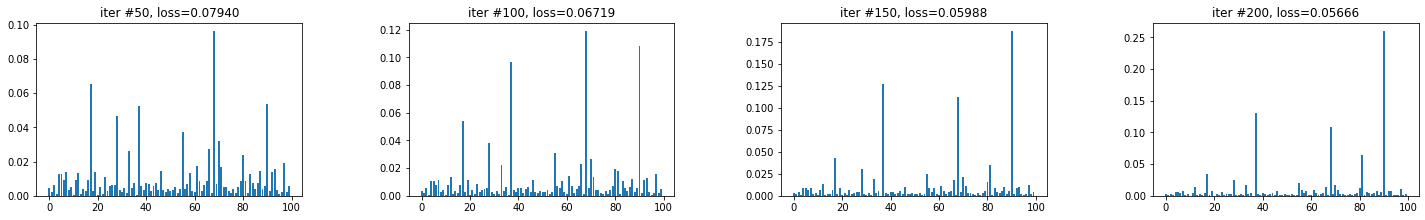

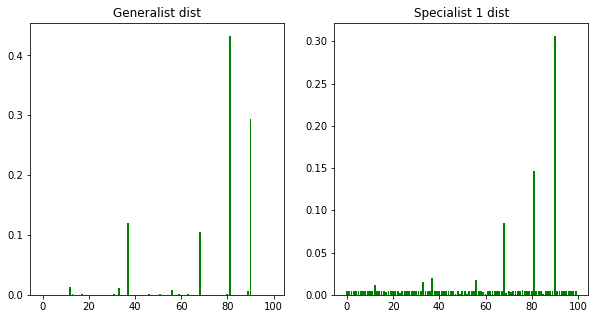

In [37]:
# Case 1: Generalist correct, specialist 1 incorrect, ensemble prediction incorrect (index = 15)
for i in range(len(indices)): 
    if indices[i][7] == 15: 
        print(indices[i])
        
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history(9855, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

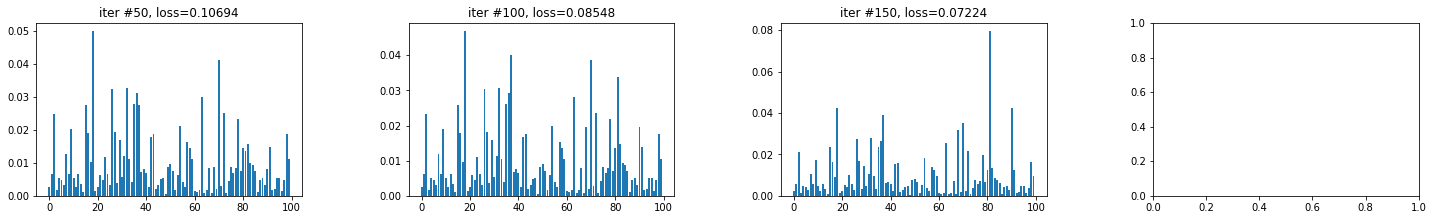

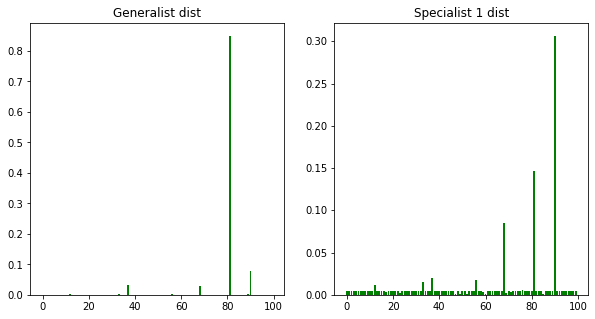

In [43]:
# If we modify the logit of the generalist model (i.e., increase the logit value of class 81 (the true label)), 
# the ensemble gets the right prediction. 
output_copy = outputs.clone() 
modified_output = output_copy
modified_output[81] = modified_output[81] + 2.0

predicted, q_dist, history = get_predicted_class_multiple(preds, modified_output, specialist_outputs, specialist_outputs_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, modified_output, specialist_outputs, specialist_outputs_2, sub_classes)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3

True label: tensor([81], device='cuda:0')


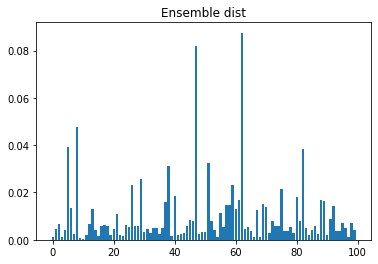

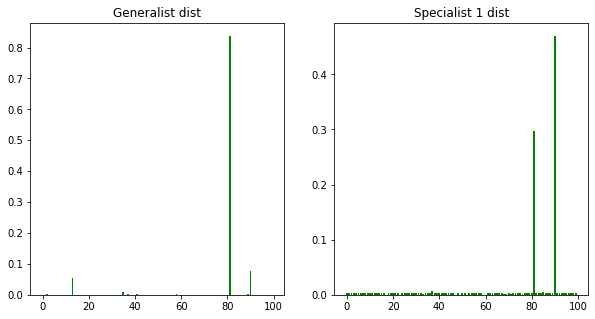

In [45]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history(9454, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
#q_fig = plot_iteration_history(history)
plt.figure()
q_dist = q_dist.detach().cpu().numpy()
plt.bar(np.arange(q_dist.shape[0]), softmax(q_dist))
plt.title("Ensemble dist")
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

In [131]:
def retrieve_iteration_history_modified(index, testloader, generalist_model, specialist_model_1, specialist_model_2, sub_classes): 
    
    """ 
    This function is similar to the function retrieve_iteration_history_modified. However, we use
    the modified iterative algorithm (i.e., get_predicted_class_multiple_modified) here. 
    """
    generalist_model.eval() 
    specialist_model_1.eval() 
    specialist_model_2.eval()
    
    for i, data in enumerate(testloader, 0): 
        if i != index: 
            continue 
        
        inputs, labels = data 
        if torch.cuda.is_available(): 
            inputs, labels = inputs.cuda(), labels.cuda() 
            
        outputs = generalist_model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        specialist_outputs = specialist_model_1(inputs)
        _, specialist_preds = torch.max(specialist_outputs.data, 1)
        
        specialist_outputs_2 = specialist_model_2(inputs)
        _, specialist_preds_2 = torch.max(specialist_outputs_2.data, 1)
        
        predicted, q_dist, history = get_predicted_class_multiple_modified(preds[0], outputs[0], specialist_outputs[0], specialist_outputs_2[0], sub_classes)
        
        return preds[0], outputs[0], specialist_outputs[0], specialist_outputs_2[0], labels, predicted, q_dist, history

def get_predicted_class_multiple_modified(baseline_class, generalist_output, specialist_output, specialist_output_2, sub_classes): 
     
    """ 
    This function is similar to the function get_predicted_class_multiple. However, we modify the stopping 
    criteria of the iterative algorithm here. We run the algorithm for 300 iterations here, instead of 
    stopping it as soon as the loss value diverges. 
    """
    specialist_outputs = []
    specialist_outputs.append(specialist_output)
    specialist_outputs.append(specialist_output_2)
    
    num_classes = 100 
    q_dist = torch.randn(num_classes, requires_grad = True, device = "cuda:0")

    optimizer = optim.Adam([q_dist], lr = 0.1)
    criterion = nn.KLDivLoss() 
    previous_loss = 10000.0
    loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
    

    num_specialists = len(sub_classes)
    for i in range(num_specialists):
        sub_class = sub_classes[i]
        if baseline_class in sub_class: 
            modified_q_dist = np.zeros(len(sub_class) + 1)
            q_dist_copy = q_dist.clone() 
            for index in range(len(sub_class)): 
                modified_q_dist[index] = q_dist_copy[sub_class[index]]
                q_dist_copy[sub_class[index]] = 0.0 
                
            modified_q_dist[len(sub_class)] = torch.sum(q_dist_copy)
            modified_q_dist = torch.tensor(modified_q_dist)
            if torch.cuda.is_available(): 
                modified_q_dist = modified_q_dist.cuda()
                
            loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_outputs[i]))
            
        
    niter = 0
    history = OrderedDict()
    
    #while loss > 1e-3: 
    #while previous_loss > loss and loss > 1e-3:
    for epoch in range(300): 
        previous_loss = loss 
        loss.backward(retain_graph = True)
        optimizer.step()
        optimizer.zero_grad()
        loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
        
        for i in range(num_specialists): 
            sub_class = sub_classes[i]
            if baseline_class in sub_class: 
                modified_q_dist = np.zeros(len(sub_class) + 1)
                q_dist_copy = q_dist.clone() 
                for index in range(len(sub_class)): 
                    modified_q_dist[index] = q_dist_copy[sub_class[index]]
                    q_dist_copy[sub_class[index]] = 0.0 
                    
                modified_q_dist[len(sub_class)] = torch.sum(q_dist_copy)
                modified_q_dist = torch.tensor(modified_q_dist)
                if torch.cuda.is_available(): 
                    modified_q_dist = modified_q_dist.cuda()
                    
                loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_outputs[i]))
        
        niter+=1
        if niter % 50 == 0:
            #print("i: {:>4}, loss: {:.7f}".format(niter, loss))
            history[niter]=dict(logit=q_dist.detach().clone(), loss=loss.detach().clone())
            
    _, predicted = torch.max(q_dist.data, 0)
    return predicted, q_dist, history

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([81], device='cuda:0')


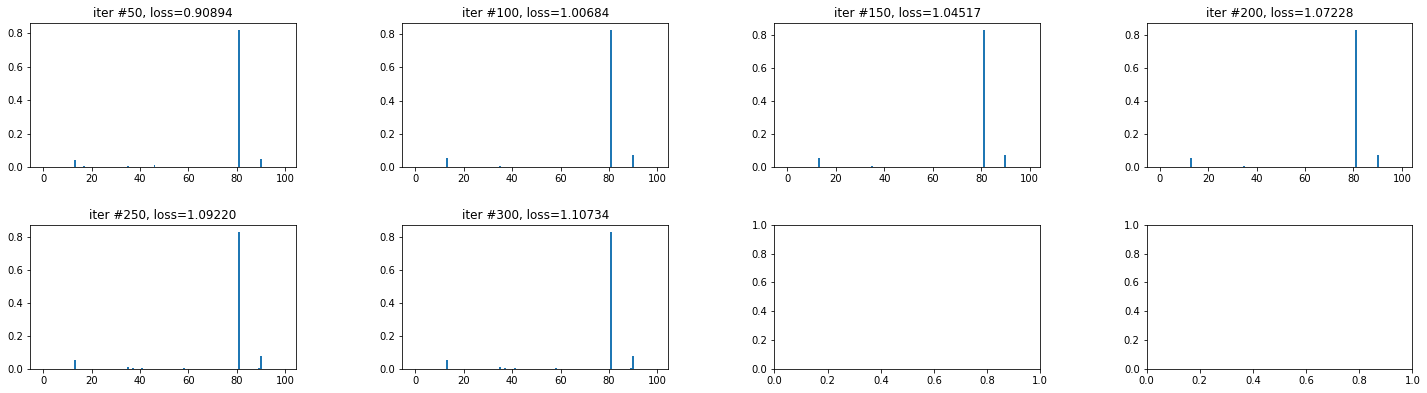

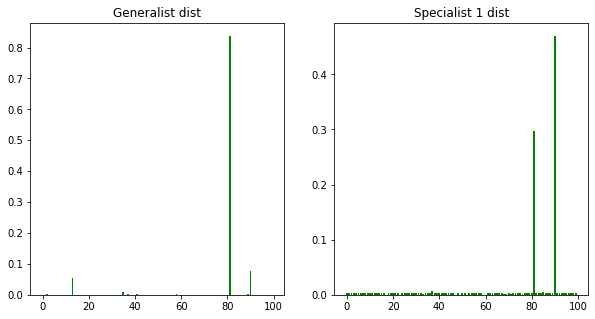

In [68]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(9454, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

For case 9454, the generalist model is very confident about its prediction. The ensemble, however, not only failed to make the right prediction, but also to 
converge to a distribution that resembles either the generalist or specialist model. We see that the loss starts to diverge after only 19 iterations. If we 
change the stopping criteria of the iterative algorithm from "while previous_loss > loss " to "for i range(num_epochs):" where num_epochs = 300, the ensemble 
is able to converge to the right probability distribution even though its loss value is diverging. 

In [69]:
# Case 2: Generalist correct, specialist 2 incorrect, ensemble prediction incorrect (index = 19)
for i in range(len(indices)): 
    if indices[i][7] == 19: 
        print(indices[i])

[149, 0, tensor(58, device='cuda:0'), tensor(58, device='cuda:0'), -1, 13, tensor(94, device='cuda:0'), 19]
[196, 0, tensor(58, device='cuda:0'), tensor(58, device='cuda:0'), -1, 89, tensor(89, device='cuda:0'), 19]
[2832, 0, tensor(13, device='cuda:0'), tensor(13, device='cuda:0'), -1, 90, tensor(85, device='cuda:0'), 19]
[5738, 0, tensor(58, device='cuda:0'), tensor(58, device='cuda:0'), -1, 90, tensor(57, device='cuda:0'), 19]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([58], device='cuda:0')


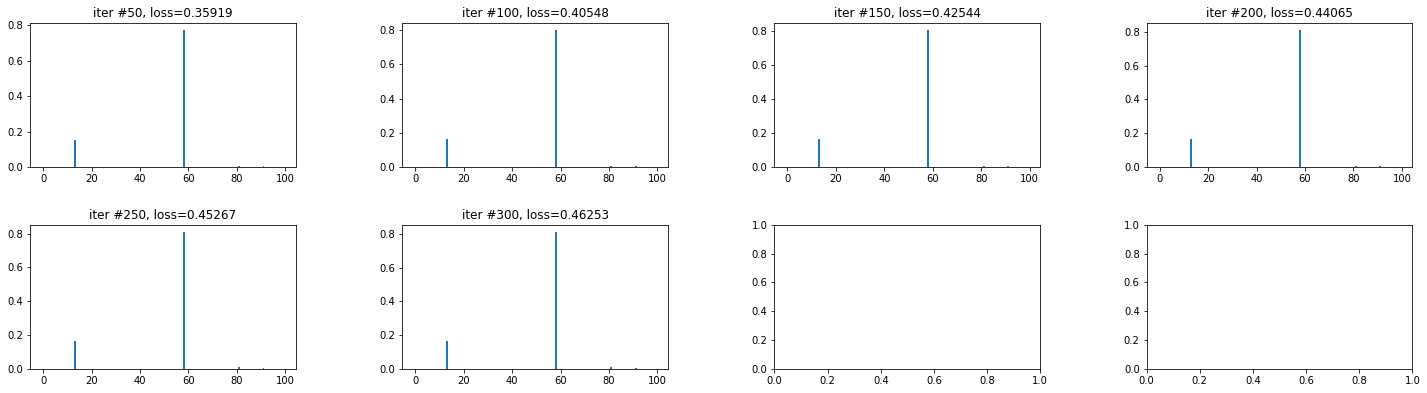

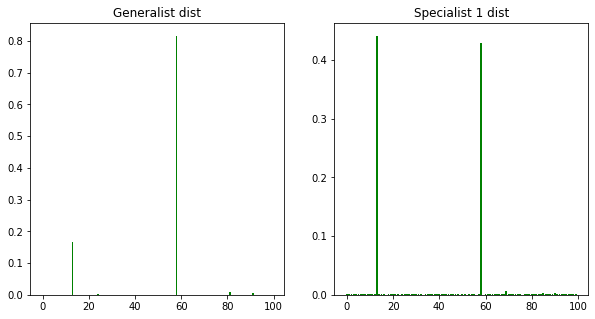

In [71]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(149, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3

True label: tensor([58], device='cuda:0')


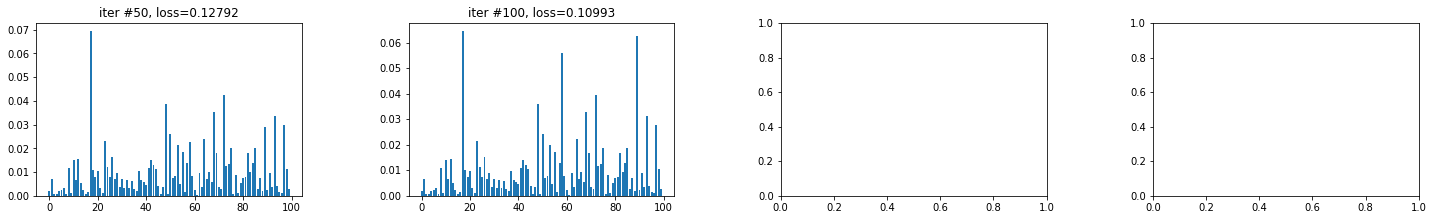

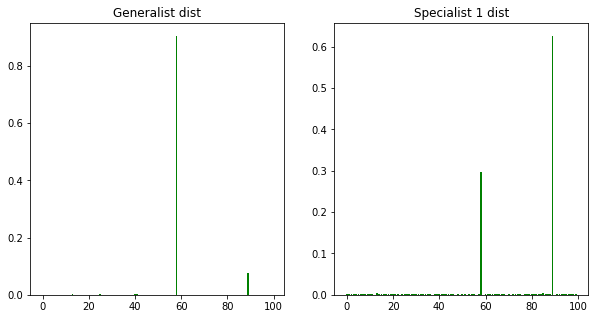

In [31]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history(196, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([58], device='cuda:0')


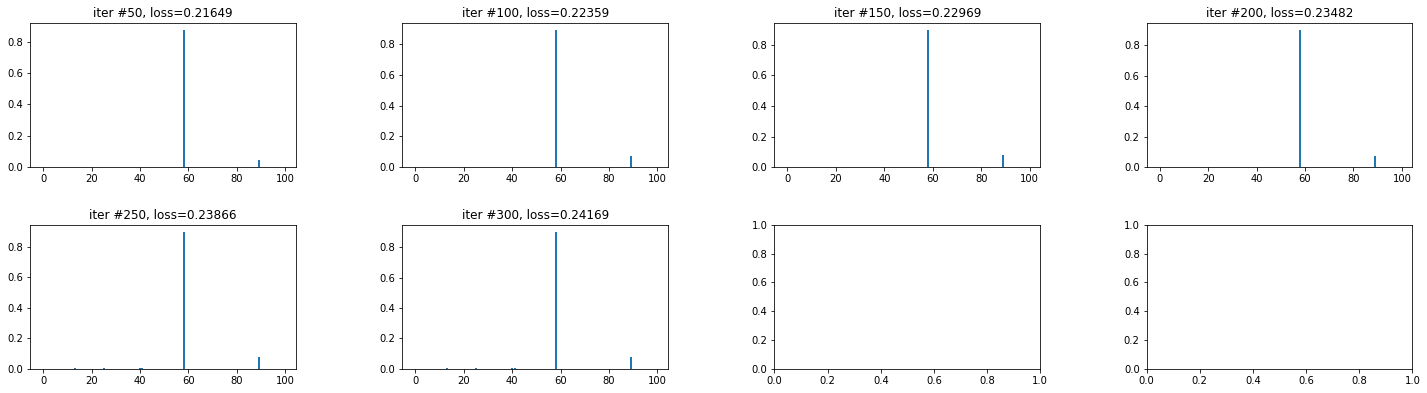

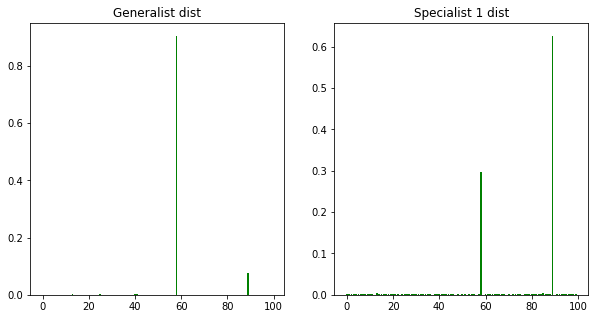

In [72]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(196, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([13], device='cuda:0')


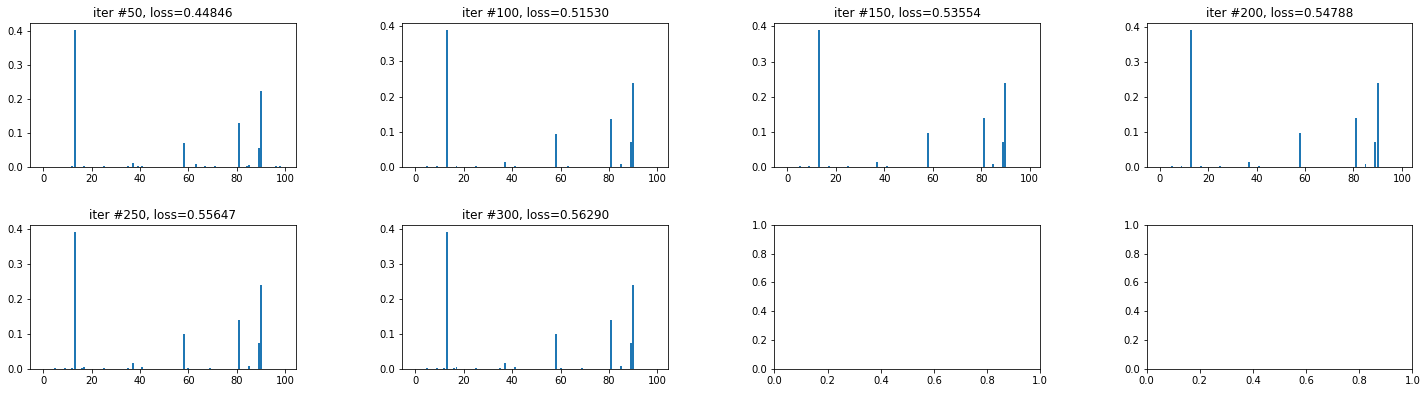

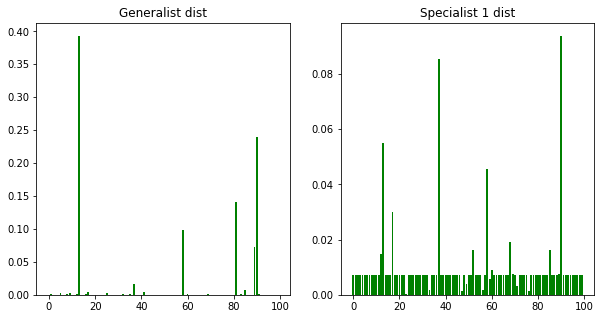

In [73]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(2832, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3

True label: tensor([58], device='cuda:0')


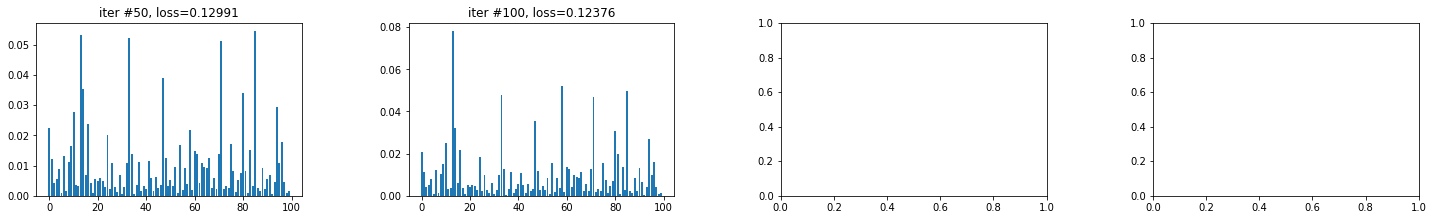

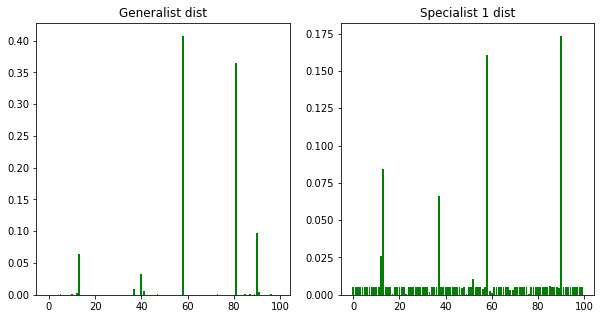

In [33]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history(5738, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([58], device='cuda:0')


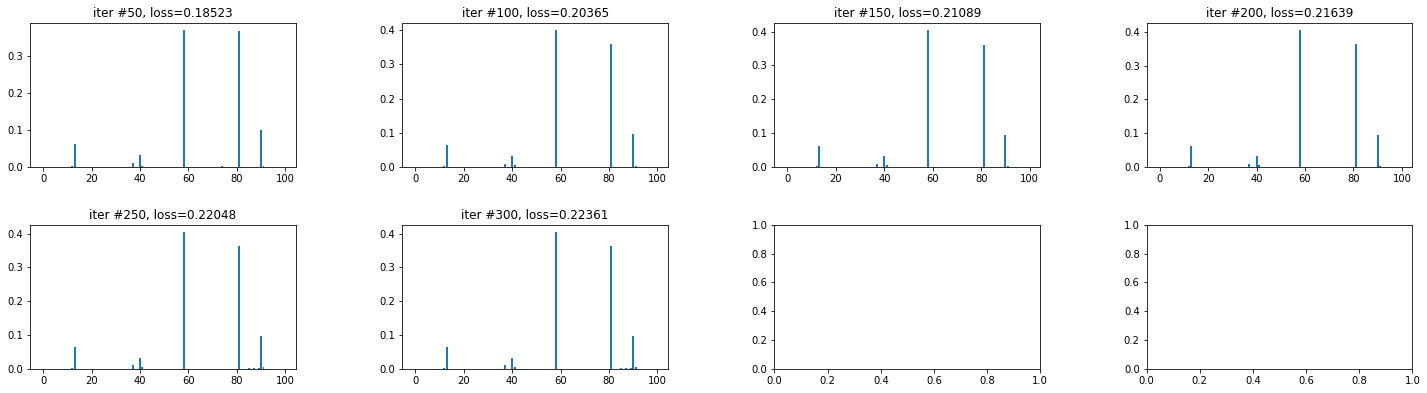

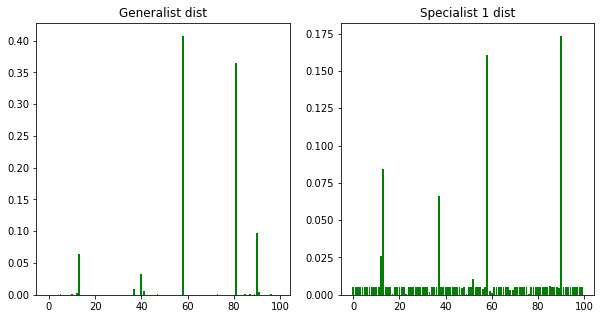

In [75]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(5738, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

In [76]:
# Case 3: Generalist incorrect, specialist 1 correct, ensemble prediction incorrect (index = 17)
for i in range(len(indices)): 
    if indices[i][7] == 17: 
        print(indices[i])

[39, 0, tensor(37, device='cuda:0'), tensor(81, device='cuda:0'), 37, -1, tensor(81, device='cuda:0'), 17]
[895, 0, tensor(37, device='cuda:0'), tensor(81, device='cuda:0'), 37, -1, tensor(25, device='cuda:0'), 17]
[3288, 0, tensor(90, device='cuda:0'), tensor(81, device='cuda:0'), 90, -1, tensor(83, device='cuda:0'), 17]
[8292, 0, tensor(12, device='cuda:0'), tensor(81, device='cuda:0'), 12, -1, tensor(81, device='cuda:0'), 17]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([37], device='cuda:0')


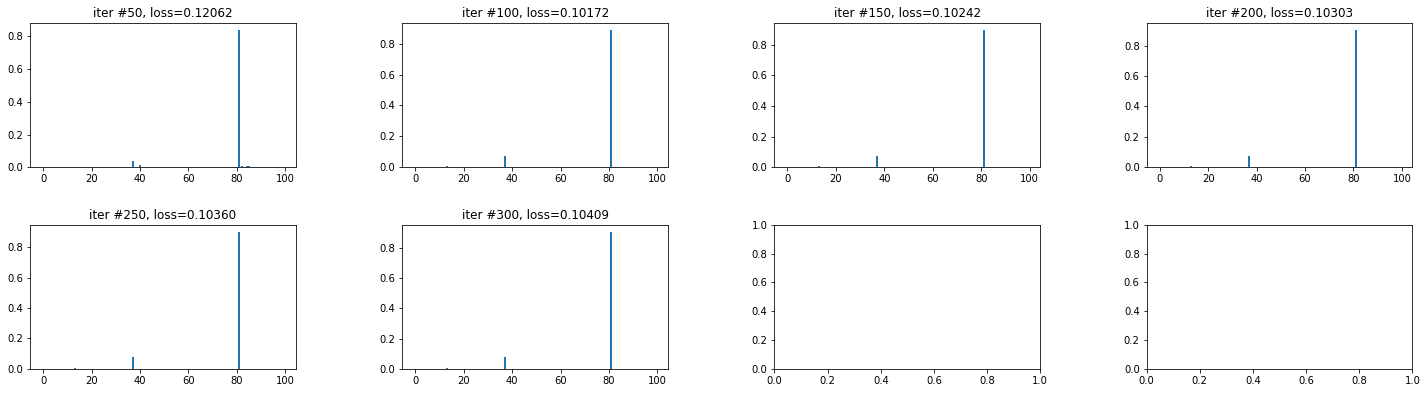

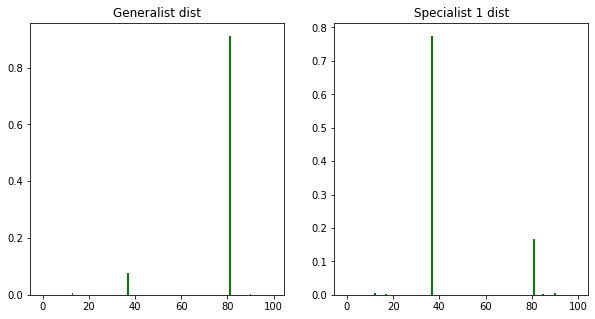

In [77]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(39, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3

True label: tensor([37], device='cuda:0')
Ensemble prediction: 81


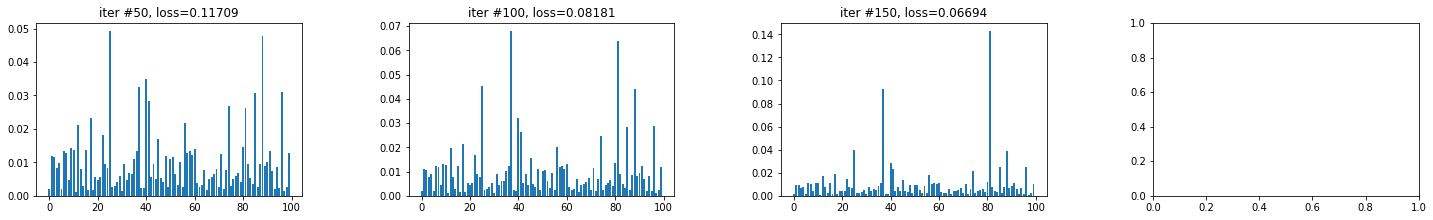

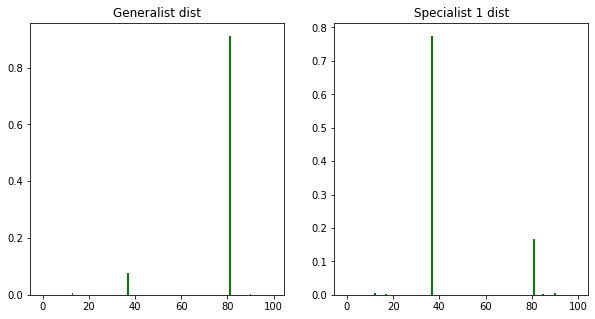

In [80]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history(39, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3

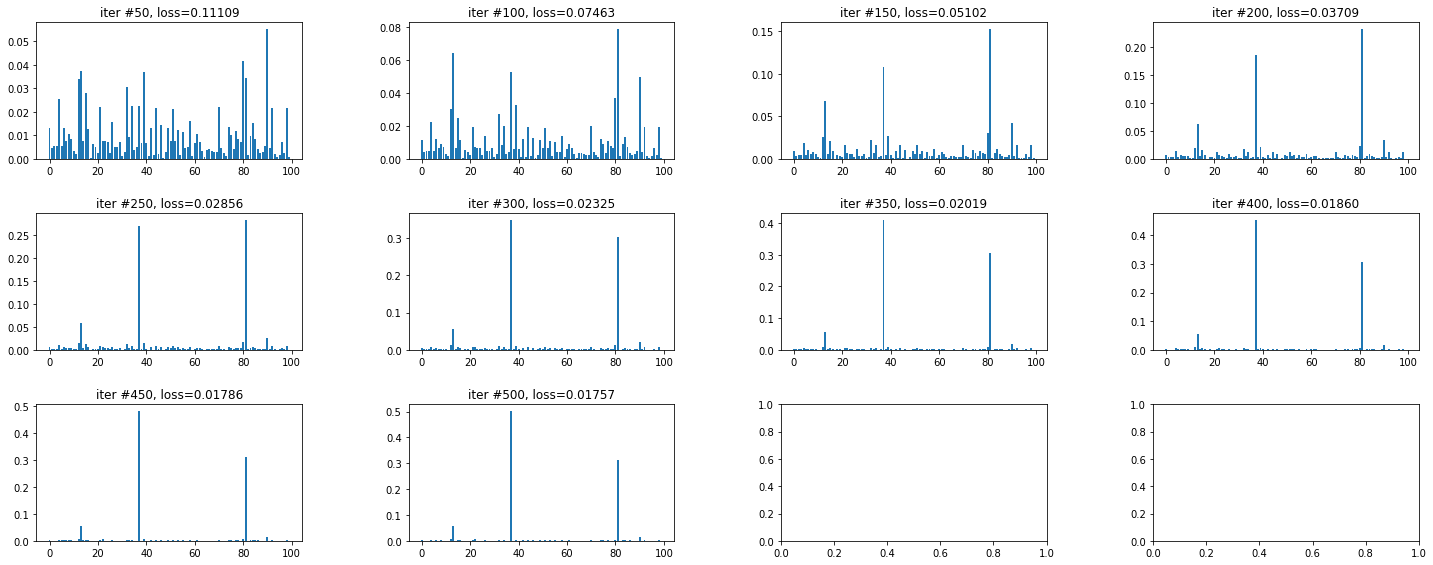

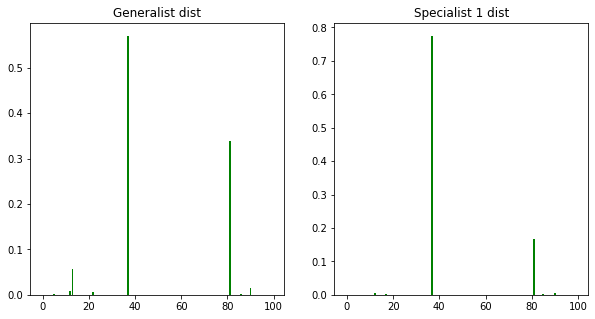

In [83]:
""" For case 39, we see that the ensemble made the wrong prediction regardless of the stopping criteria of the iterative algorithm. """

""" Here, we see that although the specialist model has the correct prediction and is extremely confident about its prediction, the
generalist model is even more confident about its prediction. Consequently, the iterative algorithm converges to a distribution that 
resembles the generalist model more than the specialist model. 
"""

""" If we lower the logit value of the generalist model for class 81, the ensemble is then able to make the correct prediction. """
output_copy = outputs.clone() 
modified_output = output_copy
modified_output[81] = modified_output[81] - 3.0

predicted, q_dist, history = get_predicted_class_multiple(preds, modified_output, specialist_outputs, specialist_outputs_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, modified_output, specialist_outputs, specialist_outputs_2, sub_classes)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([37], device='cuda:0')


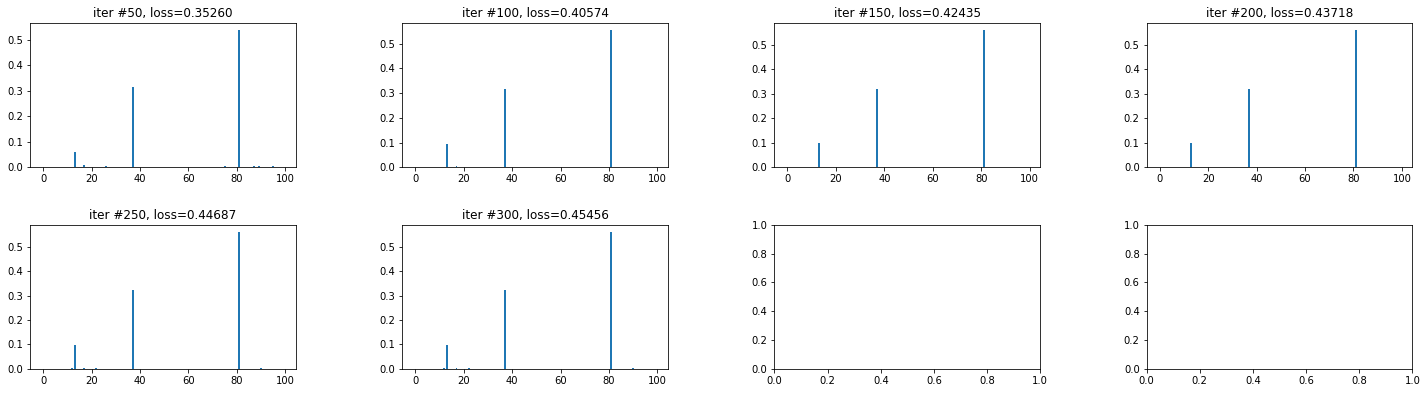

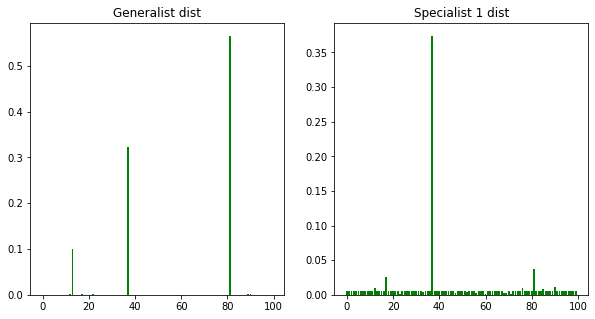

In [86]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(895, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

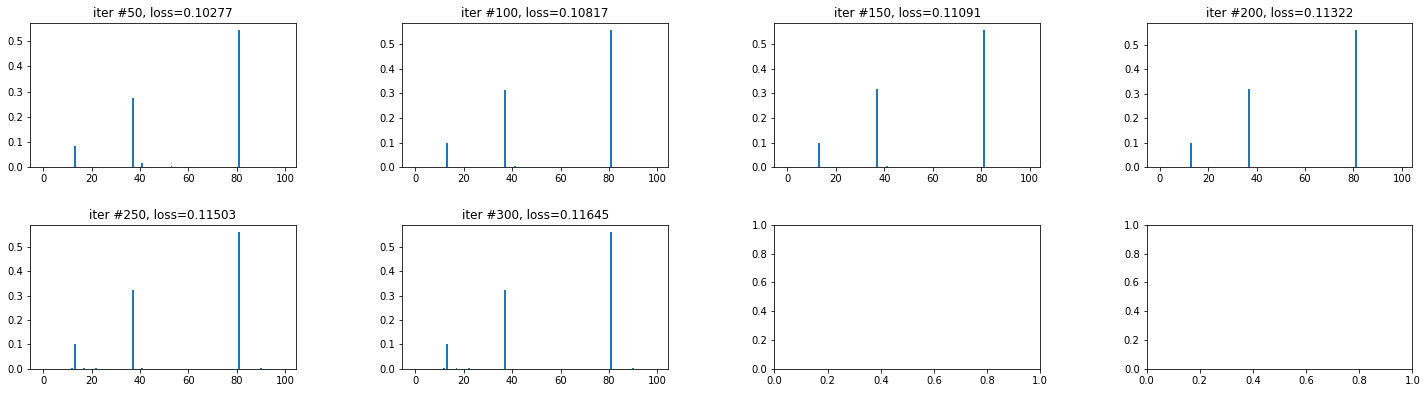

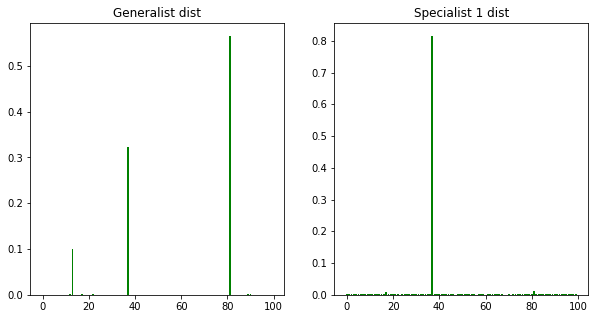

In [90]:
output_copy = specialist_outputs.clone() 
modified_specialist_outputs = output_copy
modified_specialist_outputs[sub_classes[0].index(37)] = modified_specialist_outputs[sub_classes[0].index(37)] + 2.0

predicted, q_dist, history = get_predicted_class_multiple_modified(preds, outputs, modified_specialist_outputs, specialist_outputs_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, modified_specialist_outputs, specialist_outputs_2, sub_classes)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([90], device='cuda:0')


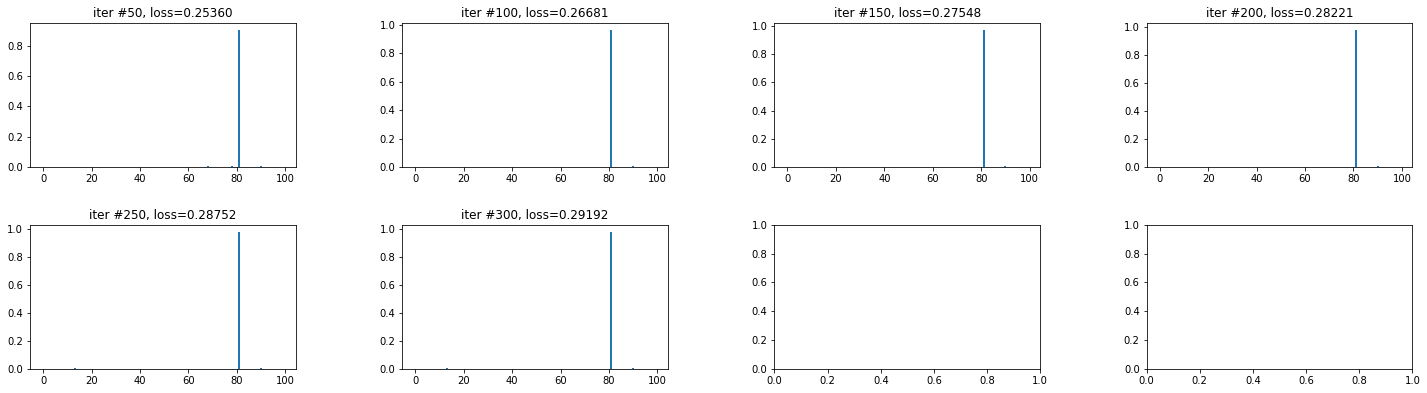

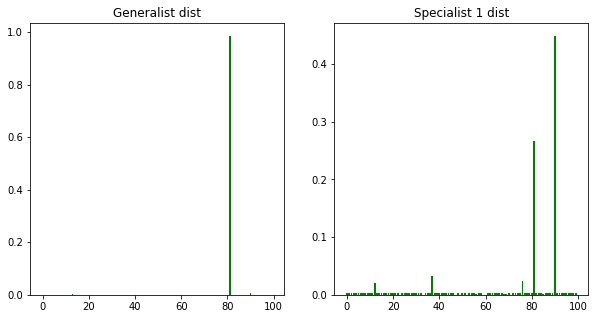

In [92]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(3288, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

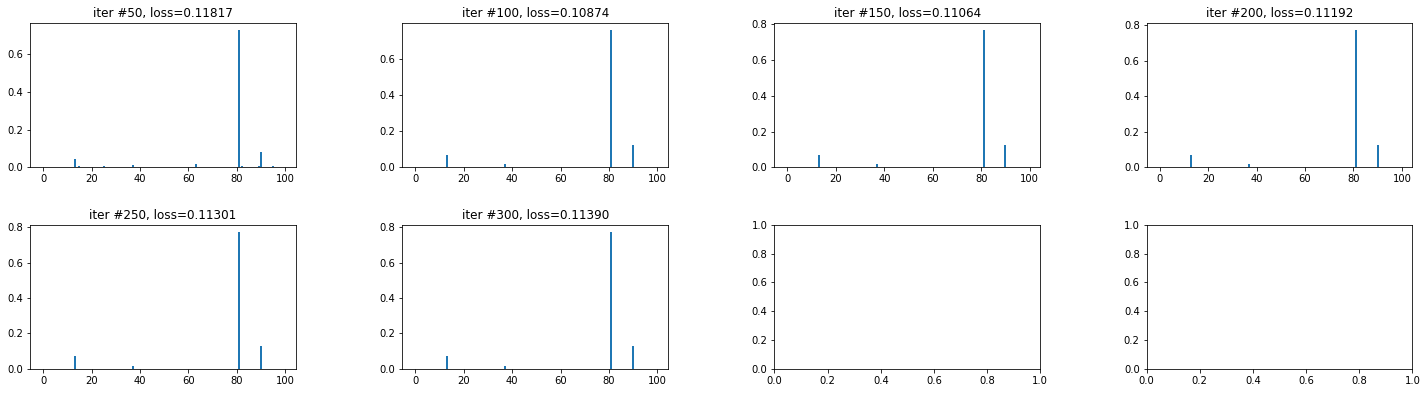

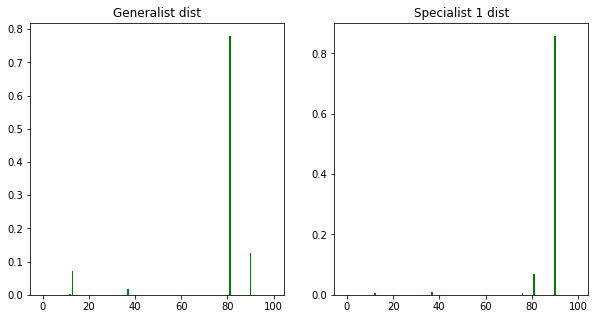

In [94]:
""" For case 3288, we see that the generalist model is extremely very confident about its prediction. """
output_copy = outputs.clone() 
modified_outputs = output_copy
modified_outputs[81] = modified_outputs[81] - 3.0
specialist_output_copy = specialist_outputs.clone() 
modified_specialist_outputs = specialist_output_copy
modified_specialist_outputs[sub_classes[0].index(90)] = modified_specialist_outputs[sub_classes[0].index(90)] + 2.0

predicted, q_dist, history = get_predicted_class_multiple_modified(preds, modified_outputs, modified_specialist_outputs, specialist_outputs_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, modified_outputs, modified_specialist_outputs, specialist_outputs_2, sub_classes)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([12], device='cuda:0')


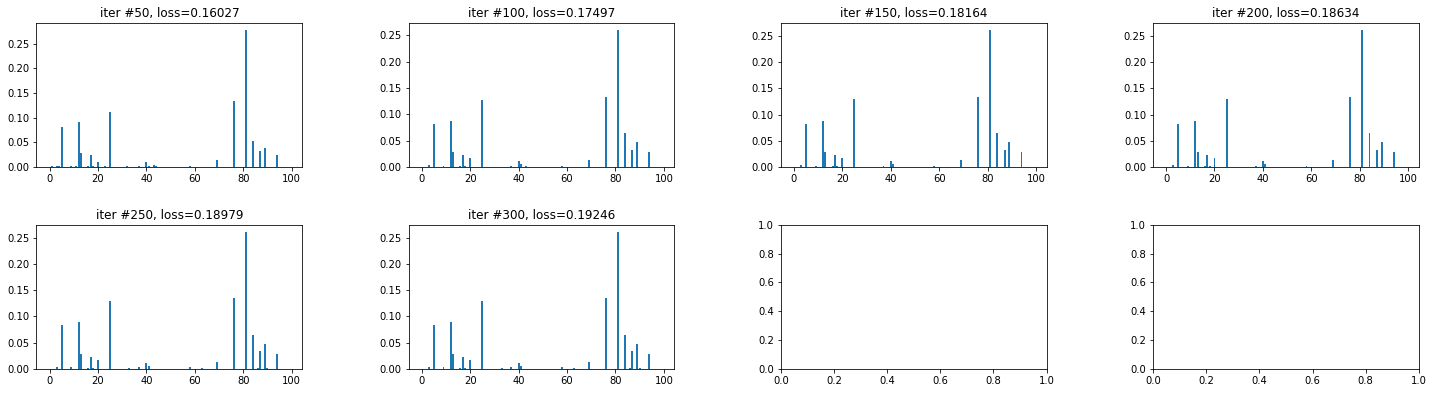

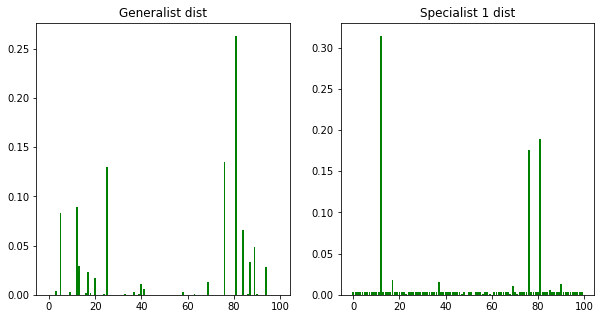

In [98]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(8292, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3

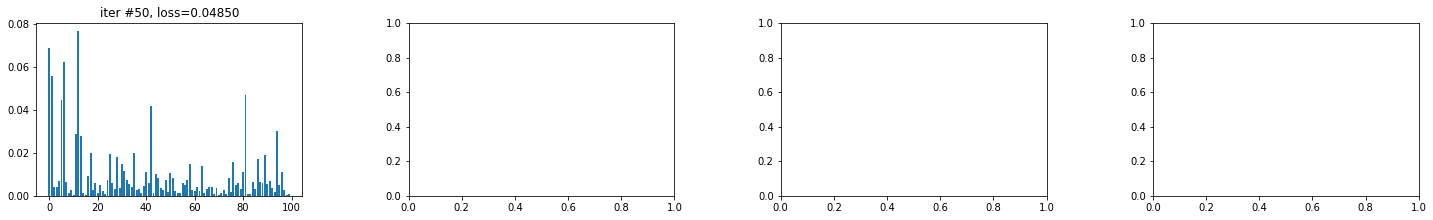

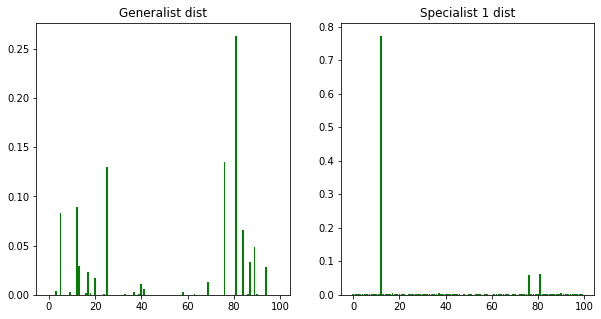

In [100]:
specialist_output_copy = specialist_outputs.clone() 
modified_specialist_outputs = specialist_output_copy
modified_specialist_outputs[sub_classes[0].index(12)] = modified_specialist_outputs[sub_classes[0].index(12)] + 2.0

predicted, q_dist, history = get_predicted_class_multiple(preds, outputs, modified_specialist_outputs, specialist_outputs_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, modified_specialist_outputs, specialist_outputs_2, sub_classes)

In [111]:
# Case 5: Generalist correct, specialist 1 correct, specialist 2 incorrect, ensemble prediction incorrect (index = 1)
for i in range(len(indices)): 
    if indices[i][7] == 1: 
        print(indices[i])

[71, 0, tensor(90, device='cuda:0'), tensor(90, device='cuda:0'), 90, 13, tensor(26, device='cuda:0'), 1]
[227, 0, tensor(76, device='cuda:0'), tensor(76, device='cuda:0'), 76, 60, tensor(14, device='cuda:0'), 1]
[888, 0, tensor(96, device='cuda:0'), tensor(96, device='cuda:0'), 96, 59, tensor(2, device='cuda:0'), 1]
[1534, 0, tensor(69, device='cuda:0'), tensor(69, device='cuda:0'), 69, 76, tensor(76, device='cuda:0'), 1]
[2288, 0, tensor(96, device='cuda:0'), tensor(96, device='cuda:0'), 96, 23, tensor(47, device='cuda:0'), 1]
[3377, 0, tensor(90, device='cuda:0'), tensor(90, device='cuda:0'), 90, 13, tensor(21, device='cuda:0'), 1]
[3802, 0, tensor(85, device='cuda:0'), tensor(85, device='cuda:0'), 85, 33, tensor(47, device='cuda:0'), 1]
[3878, 0, tensor(90, device='cuda:0'), tensor(90, device='cuda:0'), 90, 12, tensor(12, device='cuda:0'), 1]
[5188, 0, tensor(12, device='cuda:0'), tensor(12, device='cuda:0'), 12, 68, tensor(59, device='cuda:0'), 1]
[7734, 0, tensor(52, device='cuda

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([90], device='cuda:0')
Ensemble prediction: 90


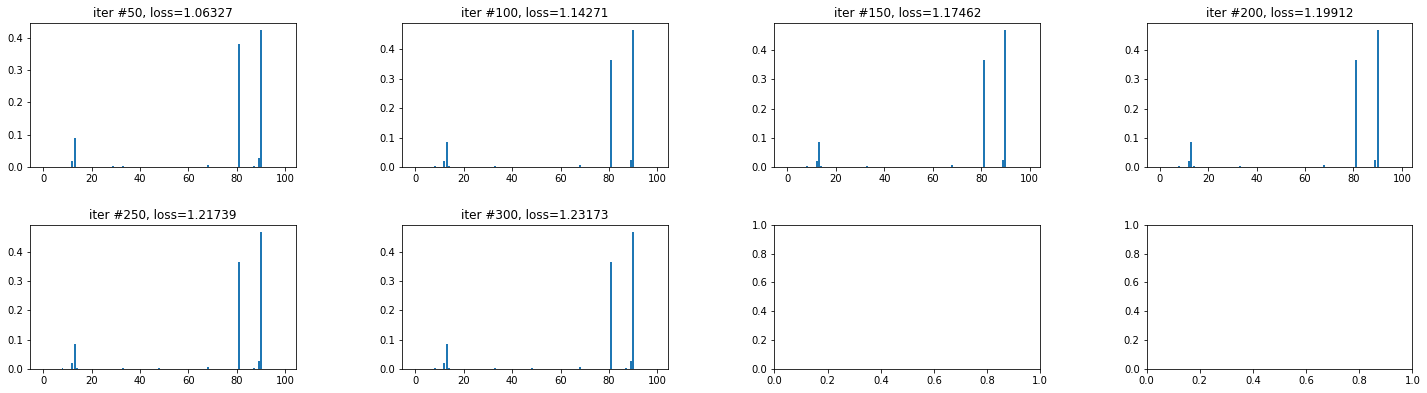

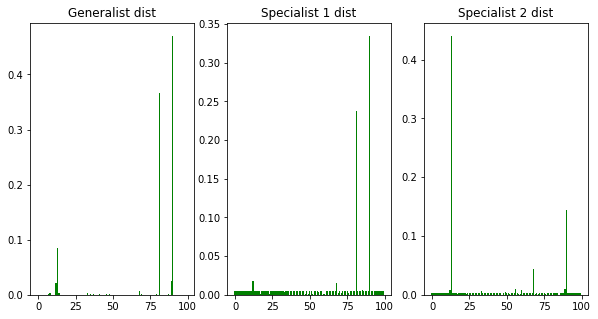

In [113]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(71, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([76], device='cuda:0')
Ensemble prediction: 76


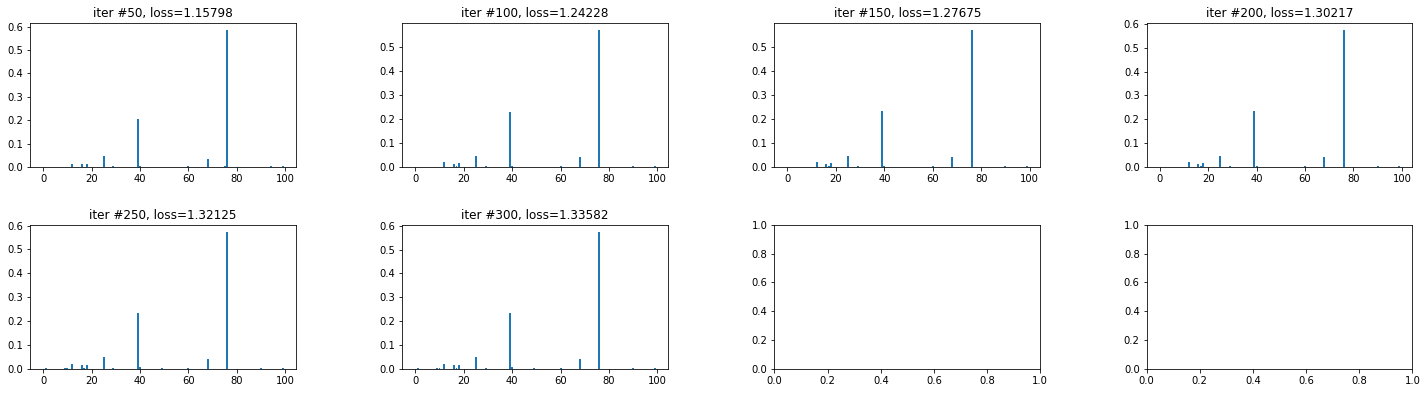

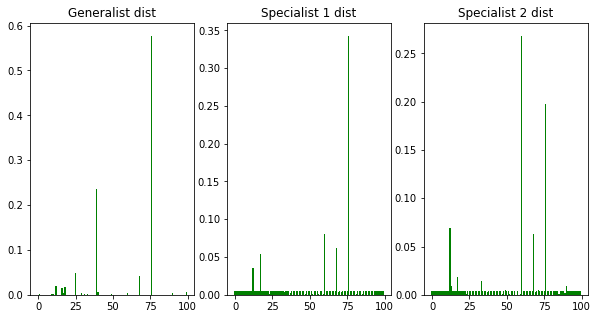

In [116]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(227, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([96], device='cuda:0')
Ensemble prediction: 96


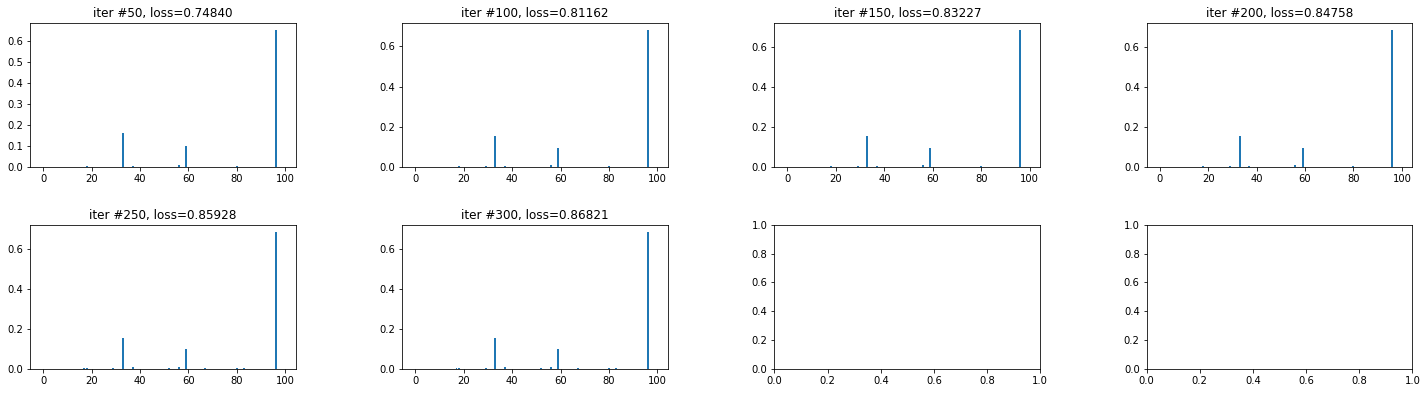

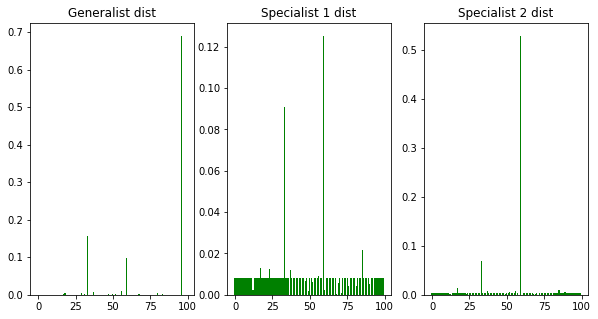

In [132]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(888, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([69], device='cuda:0')
Ensemble prediction: 69


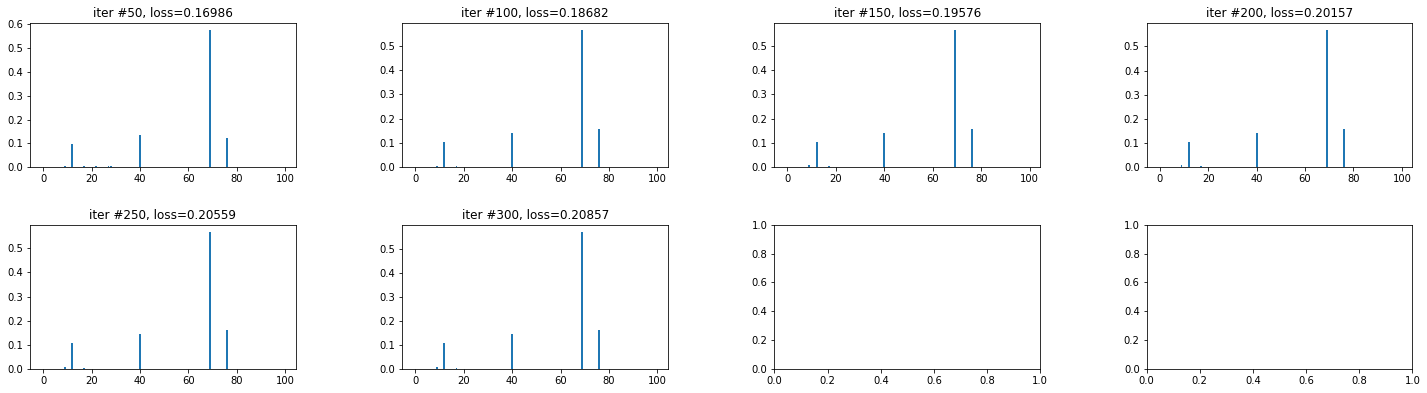

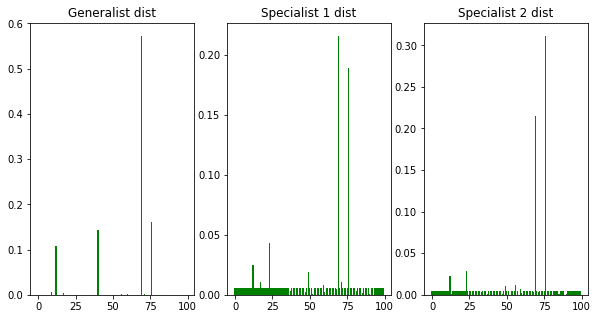

In [118]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(1534, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([96], device='cuda:0')
Ensemble prediction: 96


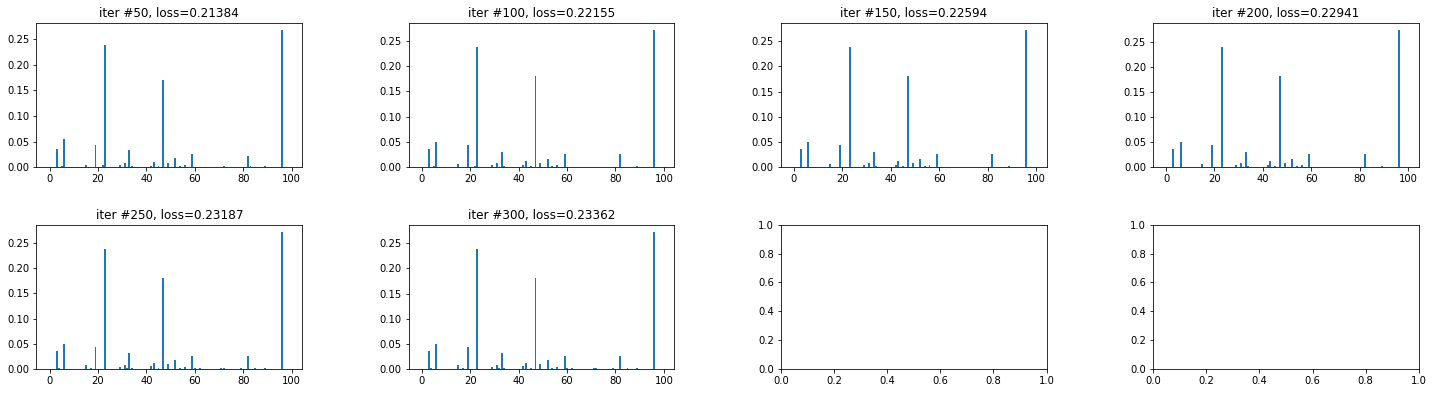

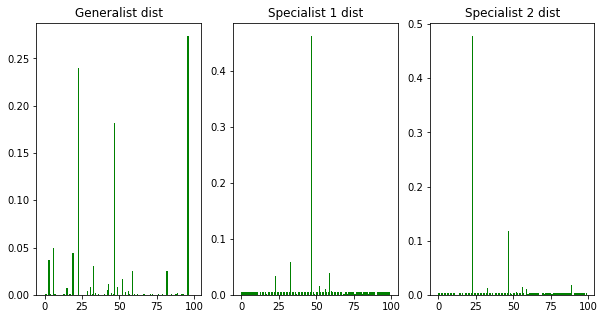

In [119]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(2288, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([90], device='cuda:0')
Ensemble prediction: 90


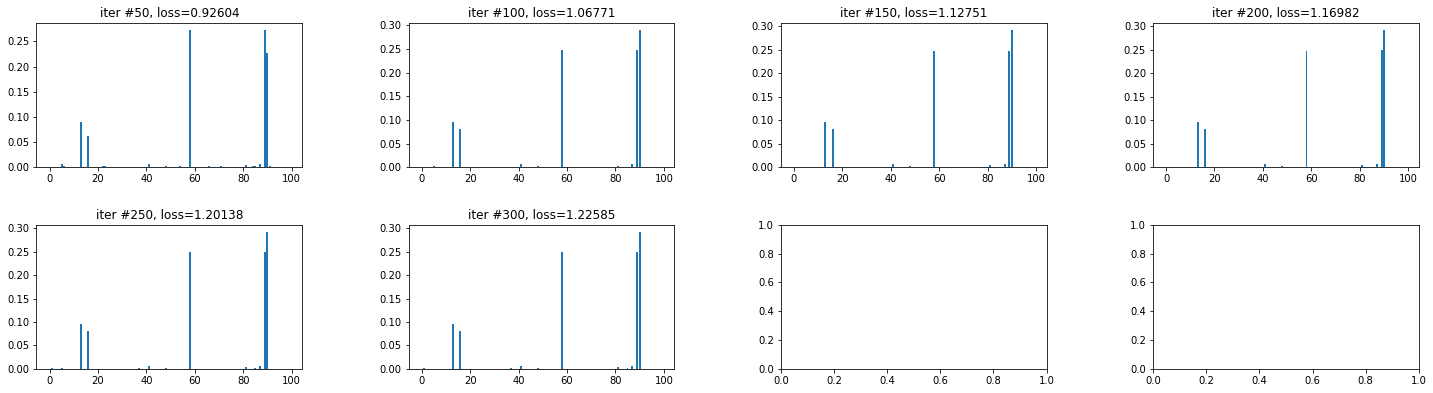

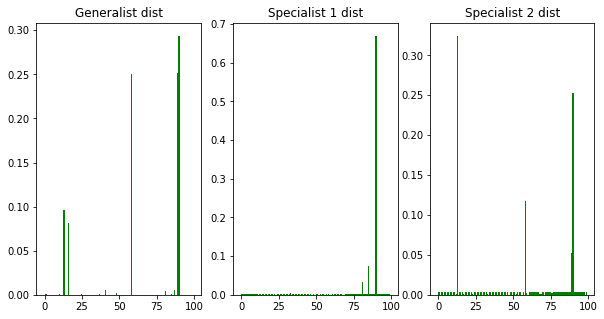

In [120]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(3377, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([85], device='cuda:0')
Ensemble prediction: 85


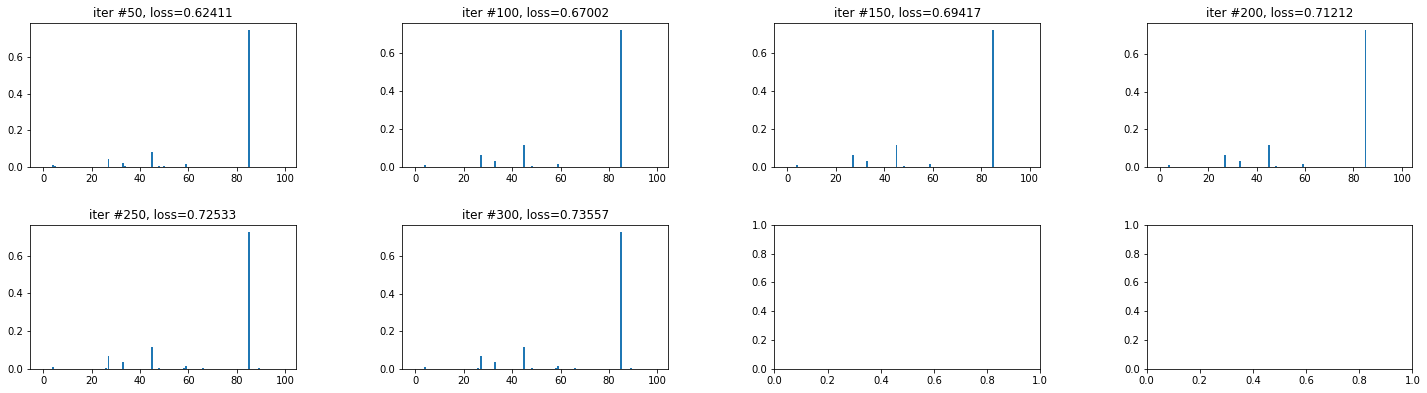

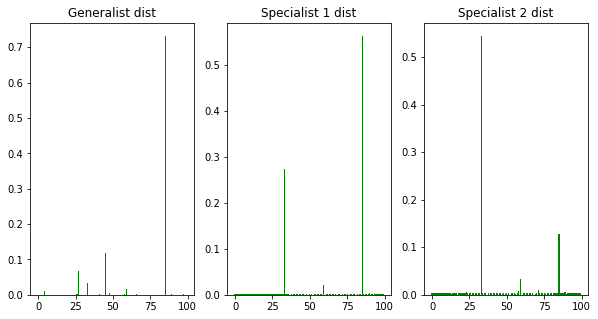

In [121]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(3802, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([90], device='cuda:0')
Ensemble prediction: 90


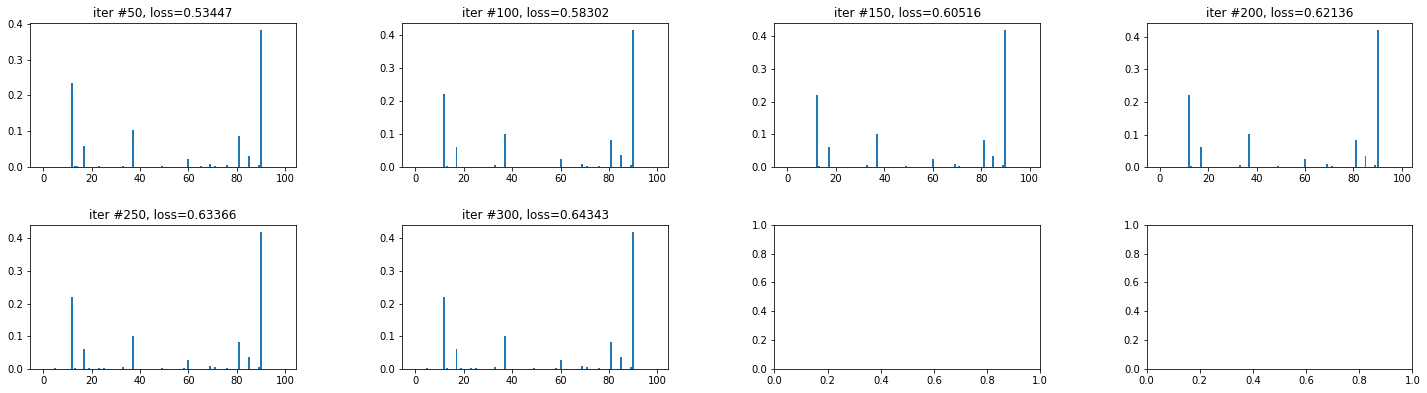

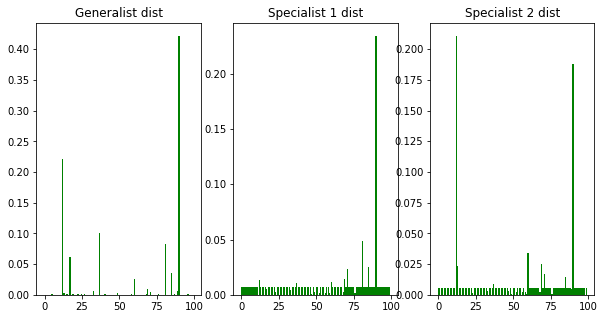

In [122]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(3878, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([12], device='cuda:0')
Ensemble prediction: 12


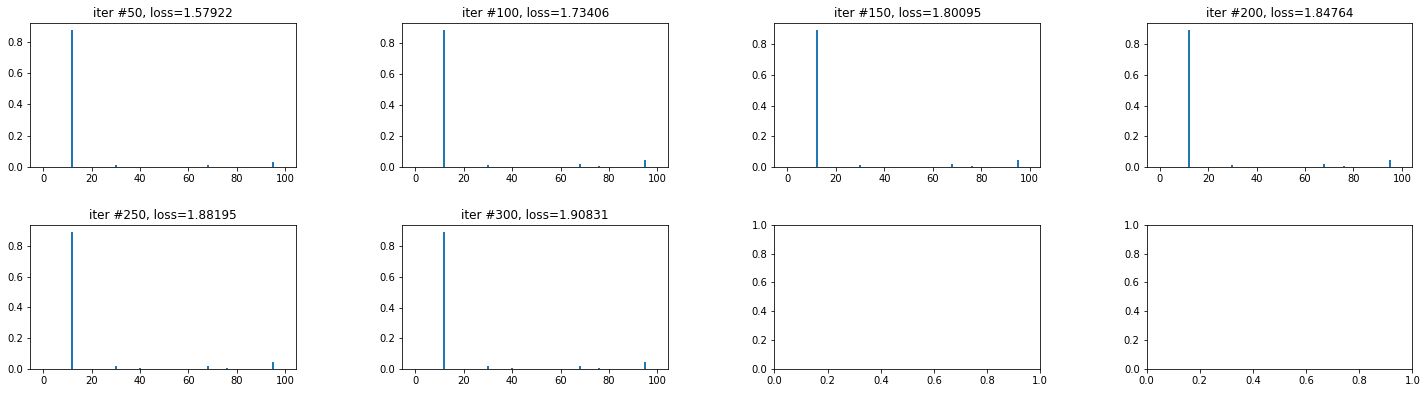

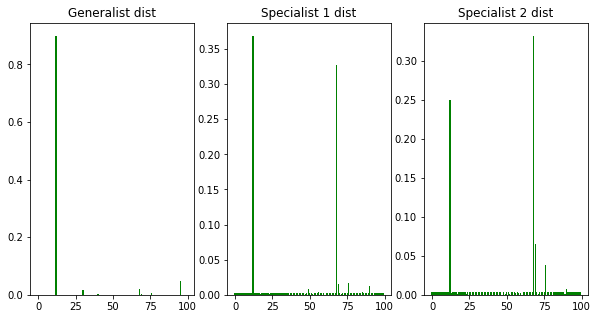

In [123]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(5188, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([52], device='cuda:0')
Ensemble prediction: 52


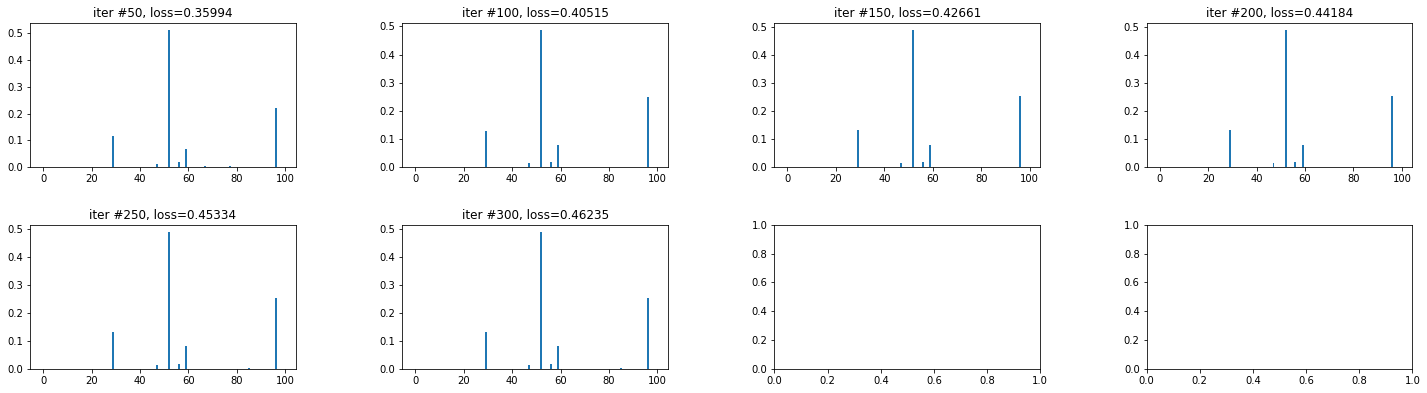

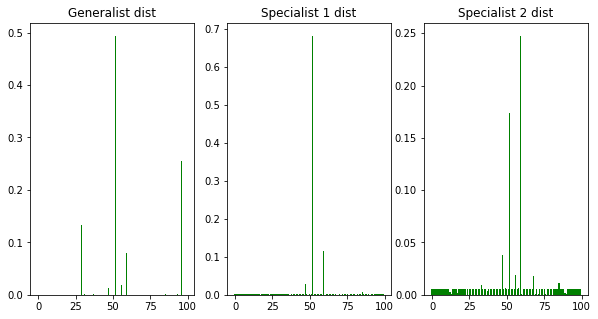

In [124]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(7734, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([37], device='cuda:0')
Ensemble prediction: 37


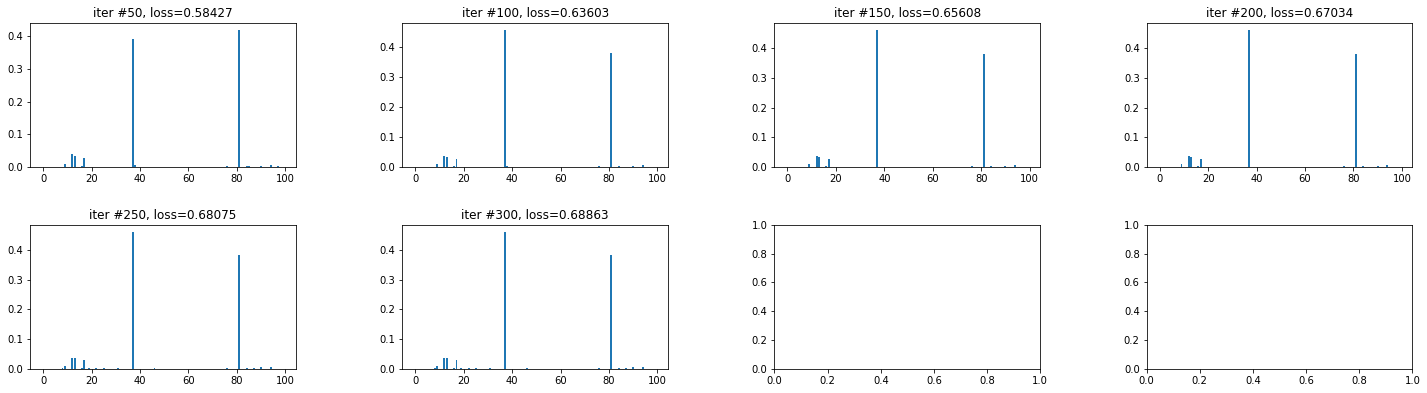

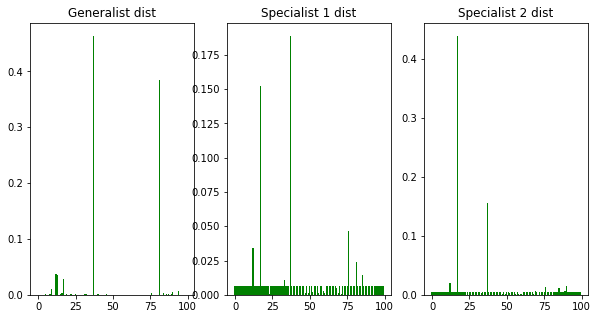

In [125]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(9685, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

In [126]:
# Case 9: Generalist incorrect, specialist 1 correct, specialist 2 correct, ensemble prediction incorrect (index = 11)
for i in range(len(indices)): 
    if indices[i][7] == 11: 
        print(indices[i])

[1681, 0, tensor(47, device='cuda:0'), tensor(52, device='cuda:0'), 47, 47, tensor(52, device='cuda:0'), 11]
[2402, 0, tensor(59, device='cuda:0'), tensor(47, device='cuda:0'), 59, 59, tensor(61, device='cuda:0'), 11]
[2588, 0, tensor(68, device='cuda:0'), tensor(60, device='cuda:0'), 68, 68, tensor(60, device='cuda:0'), 11]
[2613, 0, tensor(69, device='cuda:0'), tensor(23, device='cuda:0'), 69, 69, tensor(77, device='cuda:0'), 11]
[2696, 0, tensor(71, device='cuda:0'), tensor(69, device='cuda:0'), 71, 71, tensor(69, device='cuda:0'), 11]
[2913, 0, tensor(71, device='cuda:0'), tensor(60, device='cuda:0'), 71, 71, tensor(60, device='cuda:0'), 11]
[3465, 0, tensor(56, device='cuda:0'), tensor(59, device='cuda:0'), 56, 56, tensor(59, device='cuda:0'), 11]
[3600, 0, tensor(96, device='cuda:0'), tensor(33, device='cuda:0'), 96, 96, tensor(33, device='cuda:0'), 11]
[4665, 0, tensor(56, device='cuda:0'), tensor(12, device='cuda:0'), 56, 56, tensor(74, device='cuda:0'), 11]
[4893, 0, tensor(49

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([47], device='cuda:0')
Ensemble prediction: 52


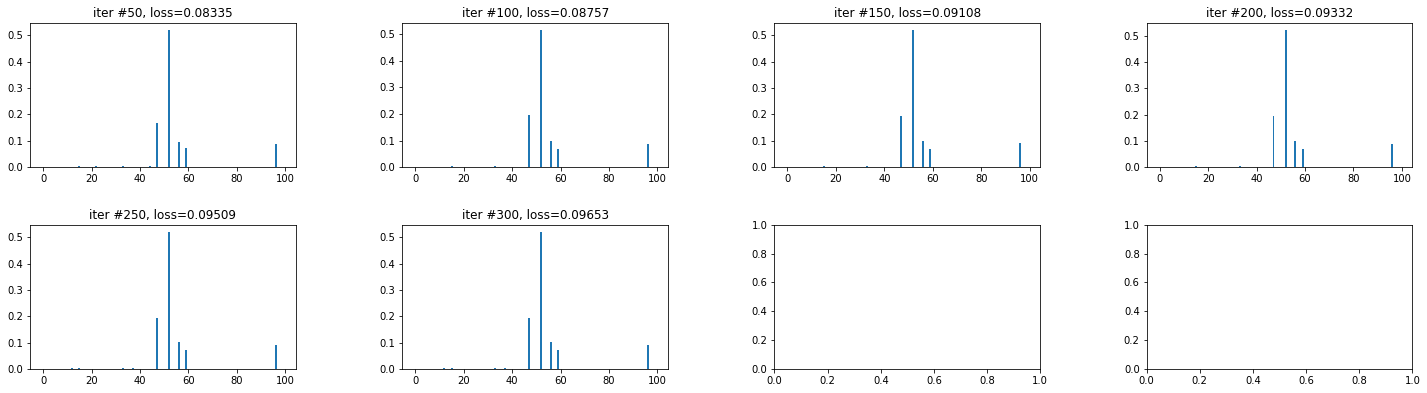

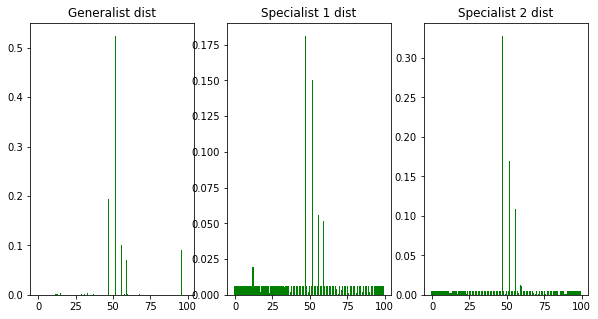

In [127]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(1681, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3

True label: tensor([47], device='cuda:0')
Ensemble prediction: 47


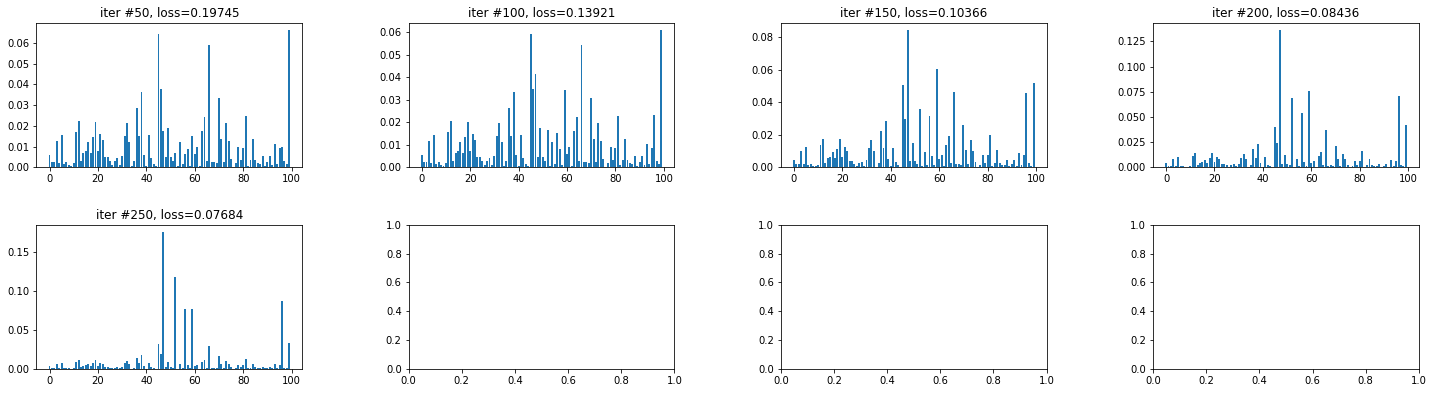

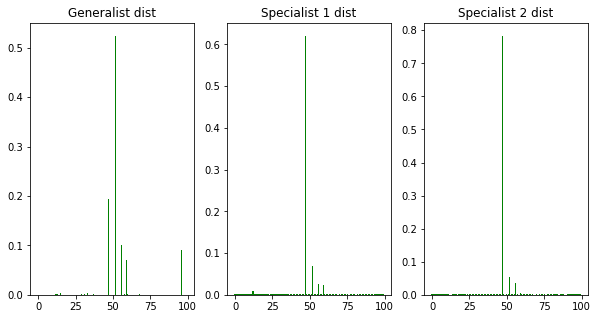

In [130]:
s_output_copy = specialist_outputs.clone() 
s_output_2_copy = specialist_outputs_2.clone() 

modified_specialist_outputs = s_output_copy
modified_specialist_outputs[sub_classes[0].index(47)] += 2.0
modified_specialist_outputs_2 = s_output_2_copy 
modified_specialist_outputs_2[sub_classes[1].index(47)] += 2.0 

predicted, q_dist, history = get_predicted_class_multiple(preds, outputs, modified_specialist_outputs, modified_specialist_outputs_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, modified_specialist_outputs, modified_specialist_outputs_2, sub_classes)
print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([59], device='cuda:0')
Ensemble prediction: 47


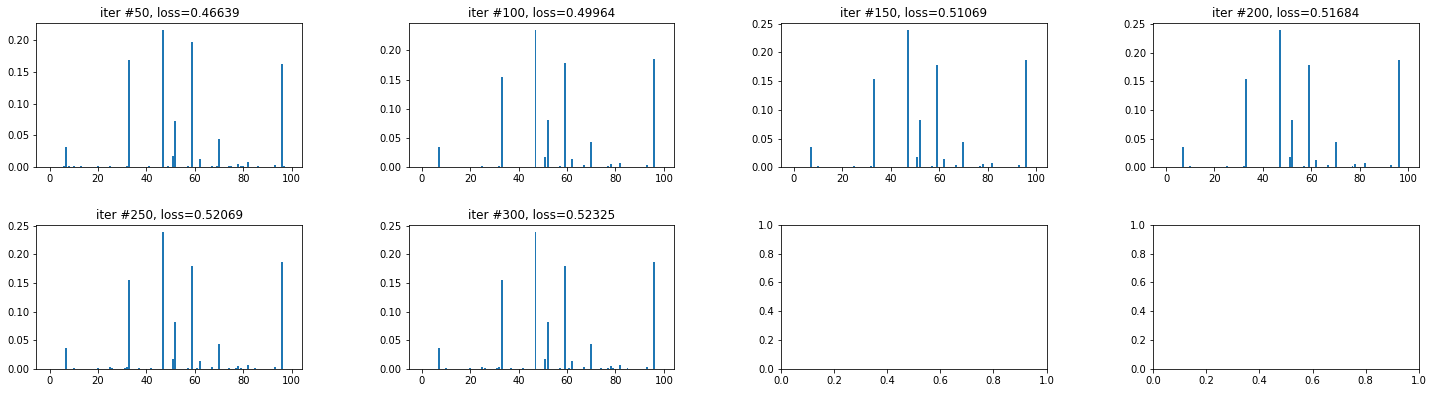

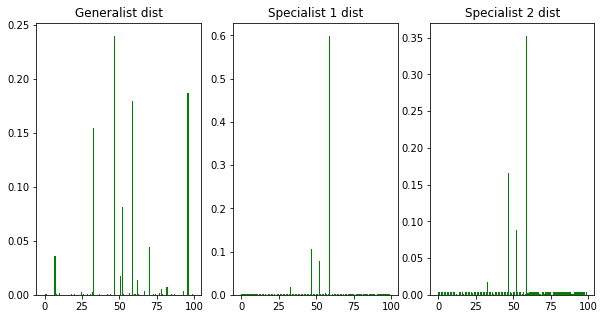

In [133]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(2402, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)

print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([59], device='cuda:0')
Ensemble prediction: 47


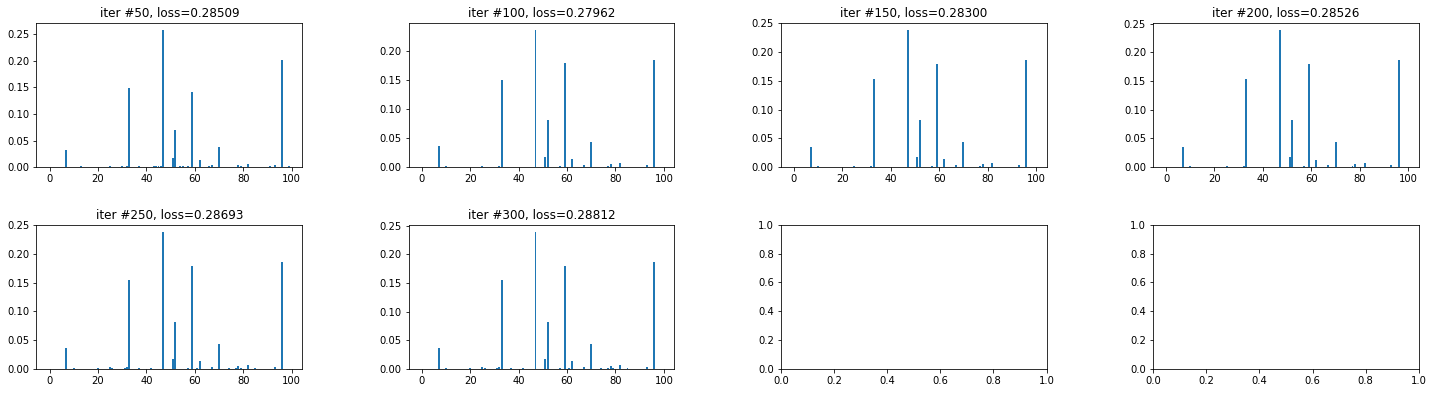

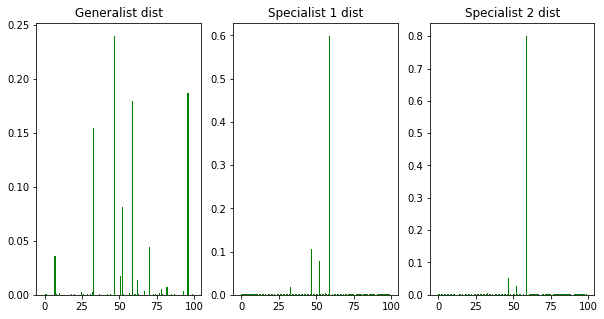

In [135]:
""" THis is a failure case. The iterative algorithm is unable to converge to the right distribution even after we modified the logits or stopping criteria. """
s_output_2_copy = specialist_outputs_2.clone() 
modified_specialist_outputs_2 = s_output_2_copy 
modified_specialist_outputs_2[sub_classes[1].index(59)] += 2.0 

predicted, q_dist, history = get_predicted_class_multiple_print(preds, outputs, specialist_outputs, modified_specialist_outputs_2, sub_classes)
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, modified_specialist_outputs_2, sub_classes)
print("True label: {}".format(labels))
print("Ensemble prediction: {}".format(predicted))

In [98]:
# Case 9: Dustbin class, ensemble wrong (index = 13)
for i in range(len(indices)): 
    if indices[i][7] == 13: 
        print(indices[i])

[10, 0, tensor(71, device='cuda:0'), tensor(12, device='cuda:0'), -1, -1, tensor(17, device='cuda:0'), 13]
[72, 0, tensor(67, device='cuda:0'), tensor(49, device='cuda:0'), -1, -1, tensor(10, device='cuda:0'), 13]
[976, 0, tensor(82, device='cuda:0'), tensor(85, device='cuda:0'), -1, -1, tensor(79, device='cuda:0'), 13]
[1594, 0, tensor(16, device='cuda:0'), tensor(12, device='cuda:0'), -1, -1, tensor(9, device='cuda:0'), 13]
[1922, 0, tensor(56, device='cuda:0'), tensor(56, device='cuda:0'), -1, -1, tensor(84, device='cuda:0'), 13]
[2351, 0, tensor(25, device='cuda:0'), tensor(69, device='cuda:0'), -1, -1, tensor(80, device='cuda:0'), 13]
[3082, 0, tensor(69, device='cuda:0'), tensor(69, device='cuda:0'), -1, -1, tensor(54, device='cuda:0'), 13]
[3279, 0, tensor(69, device='cuda:0'), tensor(69, device='cuda:0'), -1, -1, tensor(35, device='cuda:0'), 13]
[3437, 0, tensor(18, device='cuda:0'), tensor(69, device='cuda:0'), -1, -1, tensor(69, device='cuda:0'), 13]
[4065, 0, tensor(9, devic

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

True label: tensor([71], device='cuda:0'), Ensemble predicted: 12


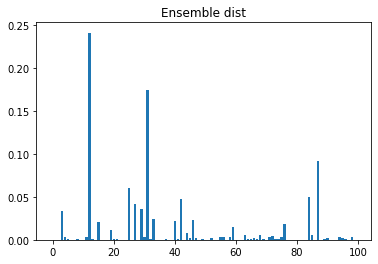

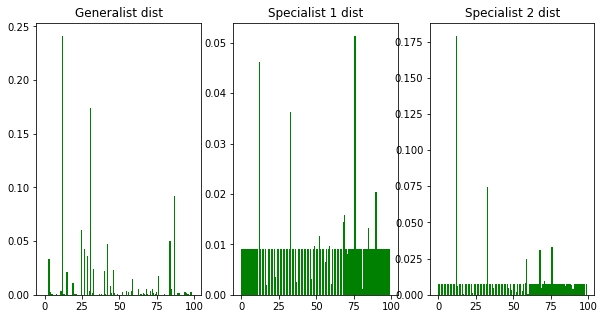

In [136]:
preds, outputs, specialist_outputs, specialist_outputs_2, labels, predicted, q_dist, history = retrieve_iteration_history_modified(10, testloader, generalist_model, specialist_model, specialist_model_2, sub_classes)
plt.figure()
q_dist = q_dist.detach().cpu().numpy()
plt.bar(np.arange(q_dist.shape[0]), softmax(q_dist))
plt.title("Ensemble dist")
all_plots = compare_q_plots(history, preds, outputs, specialist_outputs, specialist_outputs_2, sub_classes)
print("True label: {}, Ensemble predicted: {}".format(labels, predicted))

In [137]:
# What if we change the stopping criteria? Would the testing accuracy improve? 
def inspect_ensemble_predictions_modified(generalist_model, specialist_model_1, specialist_model_2, testloader, sub_classes): 
  
    generalist_model.eval() 
    specialist_model_1.eval()
    specialist_model_2.eval() 
    
    g_correct_s1_wrong_e_correct, g_correct_s1_wrong_e_wrong, g_wrong_s1_correct_e_correct, g_wrong_s1_correct_e_wrong = 0, 0, 0, 0
    g_correct_s2_wrong_e_correct, g_correct_s2_wrong_e_wrong, g_wrong_s2_correct_e_correct, g_wrong_s2_correct_e_wrong = 0, 0, 0, 0
    g_correct_s1_correct_s2_wrong_e_correct, g_correct_s1_correct_s2_wrong_e_wrong = 0, 0 
    g_correct_s1_wrong_s2_correct_e_correct, g_correct_s1_wrong_s2_correct_e_wrong = 0, 0 
    g_correct_s1_wrong_s2_wrong_e_correct, g_correct_s1_wrong_s2_wrong_e_wrong = 0, 0 
    g_wrong_s1_correct_s2_correct_e_correct, g_wrong_s1_correct_s2_correct_e_wrong = 0, 0 
    g_wrong_s1_wrong_s2_correct_e_correct, g_wrong_s1_wrong_s2_correct_e_wrong = 0, 0 
    g_wrong_s1_correct_s2_wrong_e_correct, g_wrong_s1_correct_s2_wrong_e_wrong = 0, 0
    s_dustbin_e_correct, s_dustbin_e_wrong = 0, 0 
    
    indices = [] 
  
    for i, data in enumerate(testloader, 0): 
        inputs, labels = data 
        if torch.cuda.is_available(): 
            inputs, labels = inputs.cuda(), labels.cuda() 
            
        outputs = generalist_model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        specialist_outputs = specialist_model_1(inputs)
        _, specialist_preds = torch.max(specialist_outputs.data, 1)
        
        specialist_outputs_2 = specialist_model_2(inputs)
        _, specialist_preds_2 = torch.max(specialist_outputs_2.data, 1)
        
        num_examples_per_batch = labels.shape[0]
        for index in range(num_examples_per_batch): 
            pred, label = preds[index], labels[index]
            
            if pred in sub_classes[0] and pred in sub_classes[1]: 
                
                if specialist_preds[index] != len(sub_classes[0]) and specialist_preds_2[index] != len(sub_classes[1]): 
                    sub_class = sub_classes[0]
                    sub_class_2 = sub_classes[1]
                    specialist_pred = sub_class[specialist_preds[index]]
                    specialist_pred_2 = sub_class_2[specialist_preds_2[index]]
                    
                    if pred == label and specialist_pred == label and specialist_pred_2 != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred, 0])
                            g_correct_s1_correct_s2_wrong_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred, 1])
                            g_correct_s1_correct_s2_wrong_e_wrong += 1 
                    
                    elif pred == label and specialist_pred != label and specialist_pred_2 == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 2])
                            g_correct_s1_wrong_s2_correct_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 3])
                            g_correct_s1_wrong_s2_correct_e_wrong += 1                     
            

                    elif pred == label and specialist_pred != label and specialist_pred_2 != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 4])
                            g_correct_s1_wrong_s2_wrong_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 5])
                            g_correct_s1_wrong_s2_wrong_e_wrong += 1 
            
                    elif pred != label and specialist_pred == label and specialist_pred_2 != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 6])
                            g_wrong_s1_correct_s2_wrong_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 7])
                            g_wrong_s1_correct_s2_wrong_e_wrong += 1 
            

                    elif pred != label and specialist_pred != label and specialist_pred_2 == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred,8])
                            g_wrong_s1_wrong_s2_correct_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 9])
                            g_wrong_s1_wrong_s2_correct_e_wrong += 1 
                            
                    elif pred != label and specialist_pred == label and specialist_pred_2 == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 10])
                            g_wrong_s1_correct_s2_correct_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred,11])
                            g_wrong_s1_correct_s2_correct_e_wrong += 1 
                            
                else: 
                    ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                    if ensemble_pred == label: 
                        indices.append([i, index, label, pred, -1, -1, ensemble_pred,12])
                        s_dustbin_e_correct += 1 
                    else: 
                        indices.append([i, index, label, pred, -1, -1, ensemble_pred,13])
                        s_dustbin_e_wrong += 1
            
            elif pred in sub_classes[0]:  
                if specialist_preds[index] != len(sub_classes[0]):
                    sub_class = sub_classes[0]
                    specialist_pred = sub_class[specialist_preds[index]]
                    if pred == label and specialist_pred != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, -1,  ensemble_pred,14])
                            g_correct_s1_wrong_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, -1, ensemble_pred,15])
                            g_correct_s1_wrong_e_wrong += 1
                        
                    elif pred != label and specialist_pred == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index],sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, -1, ensemble_pred,16])
                            g_wrong_s1_correct_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, -1, ensemble_pred,17])
                            g_wrong_s1_correct_e_wrong += 1
                            
 
            elif pred in sub_classes[1]:  
                if specialist_preds_2[index] != len(sub_classes[1]):
                    sub_class = sub_classes[1]
                    specialist_pred = sub_class[specialist_preds_2[index]]
                    if pred == label and specialist_pred != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, -1, specialist_pred,  ensemble_pred,18])
                            g_correct_s2_wrong_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, -1, specialist_pred,ensemble_pred, 19])
                            g_correct_s2_wrong_e_wrong += 1
                        
                    elif pred != label and specialist_pred == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, -1, specialist_pred, ensemble_pred,20])
                            g_wrong_s2_correct_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, -1, specialist_pred,ensemble_pred, 21])
                            g_wrong_s2_correct_e_wrong += 1
                
                            
    stats = dict() 
    stats['g_correct_s1_wrong_e_correct'] = g_correct_s1_wrong_e_correct
    stats['g_correct_s1_wrong_e_wrong'] = g_correct_s1_wrong_e_wrong
    stats['g_wrong_s1_correct_e_correct'] = g_wrong_s1_correct_e_correct
    stats['g_wrong_s1_correct_e_wrong'] = g_wrong_s1_correct_e_wrong
    stats['g_correct_s2_wrong_e_correct'] = g_correct_s2_wrong_e_correct
    stats['g_correct_s2_wrong_e_wrong'] = g_correct_s2_wrong_e_wrong
    stats['g_wrong_s2_correct_e_correct'] = g_wrong_s2_correct_e_correct
    stats['g_wrong_s2_correct_e_wrong'] = g_wrong_s2_correct_e_wrong
    stats['g_correct_s1_wrong_s2_correct_e_correct'] = g_correct_s1_wrong_s2_correct_e_correct
    stats['g_correct_s1_wrong_s2_correct_e_wrong'] = g_correct_s1_wrong_s2_correct_e_wrong
    stats['g_correct_s1_correct_s2_wrong_e_correct'] = g_correct_s1_correct_s2_wrong_e_correct
    stats['g_correct_s1_correct_s2_wrong_e_wrong'] = g_correct_s1_correct_s2_wrong_e_wrong
    stats['g_correct_s1_wrong_s2_wrong_e_correct'] = g_correct_s1_wrong_s2_wrong_e_correct
    stats['g_correct_s1_wrong_s2_wrong_e_wrong'] = g_correct_s1_wrong_s2_wrong_e_wrong
    stats['g_wrong_s1_correct_s2_correct_e_correct'] = g_wrong_s1_correct_s2_correct_e_correct
    stats['g_wrong_s1_correct_s2_correct_e_wrong'] = g_wrong_s1_correct_s2_correct_e_wrong
    stats['g_wrong_s1_wrong_s2_correct_e_correct'] = g_wrong_s1_wrong_s2_correct_e_correct
    stats['g_wrong_s1_wrong_s2_correct_e_wrong'] = g_wrong_s1_wrong_s2_correct_e_wrong
    stats['g_wrong_s1_correct_s2_wrong_e_correct'] = g_wrong_s1_correct_s2_wrong_e_correct
    stats['g_wrong_s1_correct_s2_wrong_e_wrong'] = g_wrong_s1_correct_s2_wrong_e_wrong
    stats['s_dustbin_e_correct'] = s_dustbin_e_correct
    stats['s_dustbin_e_wrong'] = s_dustbin_e_wrong
    
    return indices, stats

In [138]:
modified_indices, modified_ensemble_stats = inspect_ensemble_predictions_modified(generalist_model, specialist_model, specialist_model_2, testloader, sub_classes)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.

In [139]:
modified_ensemble_stats

{'g_correct_s1_wrong_e_correct': 3,
 'g_correct_s1_wrong_e_wrong': 0,
 'g_wrong_s1_correct_e_correct': 0,
 'g_wrong_s1_correct_e_wrong': 4,
 'g_correct_s2_wrong_e_correct': 7,
 'g_correct_s2_wrong_e_wrong': 0,
 'g_wrong_s2_correct_e_correct': 0,
 'g_wrong_s2_correct_e_wrong': 7,
 'g_correct_s1_wrong_s2_correct_e_correct': 41,
 'g_correct_s1_wrong_s2_correct_e_wrong': 0,
 'g_correct_s1_correct_s2_wrong_e_correct': 32,
 'g_correct_s1_correct_s2_wrong_e_wrong': 0,
 'g_correct_s1_wrong_s2_wrong_e_correct': 36,
 'g_correct_s1_wrong_s2_wrong_e_wrong': 0,
 'g_wrong_s1_correct_s2_correct_e_correct': 0,
 'g_wrong_s1_correct_s2_correct_e_wrong': 34,
 'g_wrong_s1_wrong_s2_correct_e_correct': 0,
 'g_wrong_s1_wrong_s2_correct_e_wrong': 42,
 'g_wrong_s1_correct_s2_wrong_e_correct': 0,
 'g_wrong_s1_correct_s2_wrong_e_wrong': 33,
 's_dustbin_e_correct': 3,
 's_dustbin_e_wrong': 15}

In [140]:
modified_total_corrects_iterative = modified_ensemble_stats['g_correct_s1_wrong_e_correct'] + modified_ensemble_stats['g_correct_s2_wrong_e_correct'] + modified_ensemble_stats['g_wrong_s1_correct_e_correct'] + modified_ensemble_stats['g_wrong_s2_correct_e_correct'] + modified_ensemble_stats['g_correct_s1_wrong_s2_correct_e_correct'] + modified_ensemble_stats['g_correct_s1_correct_s2_wrong_e_correct'] + modified_ensemble_stats['g_correct_s1_wrong_s2_wrong_e_correct'] + modified_ensemble_stats['g_wrong_s1_correct_s2_correct_e_correct'] + modified_ensemble_stats['g_wrong_s1_wrong_s2_correct_e_correct'] + modified_ensemble_stats['g_wrong_s1_correct_s2_wrong_e_correct'] + modified_ensemble_stats['s_dustbin_e_correct']

In [141]:
print("The testing accuracy of the generalist model (Baseline accuracy) is {} %".format(evaluate(generalist_model, testloader)))
print("The testing accuracy of the ensemble is {} %".format((total_corrects + total_corrects_iterative)*100/10000))
print("The testing accuracy of the ensemble with modified stopping criteria for the iterative algorithm is {} %".format((total_corrects + modified_total_corrects_iterative)*100/10000))

The testing accuracy of the generalist model (Baseline accuracy) is 68.97 %
The testing accuracy of the ensemble is 68.68 %
The testing accuracy of the ensemble with modified stopping criteria for the iterative algorithm is 68.97 %


In [165]:
def inspect_ensemble_predictions_modified_hack(generalist_model, specialist_model_1, specialist_model_2, testloader, sub_classes): 
  
    generalist_model.eval() 
    specialist_model_1.eval()
    specialist_model_2.eval() 
    
    g_correct_s1_wrong_e_correct, g_correct_s1_wrong_e_wrong, g_wrong_s1_correct_e_correct, g_wrong_s1_correct_e_wrong = 0, 0, 0, 0
    g_correct_s2_wrong_e_correct, g_correct_s2_wrong_e_wrong, g_wrong_s2_correct_e_correct, g_wrong_s2_correct_e_wrong = 0, 0, 0, 0
    g_correct_s1_correct_s2_wrong_e_correct, g_correct_s1_correct_s2_wrong_e_wrong = 0, 0 
    g_correct_s1_wrong_s2_correct_e_correct, g_correct_s1_wrong_s2_correct_e_wrong = 0, 0 
    g_correct_s1_wrong_s2_wrong_e_correct, g_correct_s1_wrong_s2_wrong_e_wrong = 0, 0 
    g_wrong_s1_correct_s2_correct_e_correct, g_wrong_s1_correct_s2_correct_e_wrong = 0, 0 
    g_wrong_s1_wrong_s2_correct_e_correct, g_wrong_s1_wrong_s2_correct_e_wrong = 0, 0 
    g_wrong_s1_correct_s2_wrong_e_correct, g_wrong_s1_correct_s2_wrong_e_wrong = 0, 0
    s_dustbin_e_correct, s_dustbin_e_wrong = 0, 0 
    
    indices = [] 
  
    for i, data in enumerate(testloader, 0): 
        inputs, labels = data 
        if torch.cuda.is_available(): 
            inputs, labels = inputs.cuda(), labels.cuda() 
            
        outputs = generalist_model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        specialist_outputs = specialist_model_1(inputs)
        _, specialist_preds = torch.max(specialist_outputs.data, 1)
        
        specialist_outputs_2 = specialist_model_2(inputs)
        _, specialist_preds_2 = torch.max(specialist_outputs_2.data, 1)
        
        if specialist_preds in sub_classes[0]: 
            specialist_outputs[0][sub_classes[0].index(specialist_preds)] += 3.0 
        
        if specialist_preds_2 in sub_classes[1]: 
            specialist_outputs_2[0][sub_classes[1].index(specialist_preds_2)] += 3.0 
        
        num_examples_per_batch = labels.shape[0]
        for index in range(num_examples_per_batch): 
            pred, label = preds[index], labels[index]
            
            if pred in sub_classes[0] and pred in sub_classes[1]: 
                
                if specialist_preds[index] != len(sub_classes[0]) and specialist_preds_2[index] != len(sub_classes[1]): 
                    sub_class = sub_classes[0]
                    sub_class_2 = sub_classes[1]
                    specialist_pred = sub_class[specialist_preds[index]]
                    specialist_pred_2 = sub_class_2[specialist_preds_2[index]]
                    
                    if pred == label and specialist_pred == label and specialist_pred_2 != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred, 0])
                            g_correct_s1_correct_s2_wrong_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred, 1])
                            g_correct_s1_correct_s2_wrong_e_wrong += 1 
                    
                    elif pred == label and specialist_pred != label and specialist_pred_2 == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 2])
                            g_correct_s1_wrong_s2_correct_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 3])
                            g_correct_s1_wrong_s2_correct_e_wrong += 1                     
            

                    elif pred == label and specialist_pred != label and specialist_pred_2 != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 4])
                            g_correct_s1_wrong_s2_wrong_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 5])
                            g_correct_s1_wrong_s2_wrong_e_wrong += 1 
            
                    elif pred != label and specialist_pred == label and specialist_pred_2 != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 6])
                            g_wrong_s1_correct_s2_wrong_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 7])
                            g_wrong_s1_correct_s2_wrong_e_wrong += 1 
            

                    elif pred != label and specialist_pred != label and specialist_pred_2 == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred,8])
                            g_wrong_s1_wrong_s2_correct_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 9])
                            g_wrong_s1_wrong_s2_correct_e_wrong += 1 
                            
                    elif pred != label and specialist_pred == label and specialist_pred_2 == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2,ensemble_pred, 10])
                            g_wrong_s1_correct_s2_correct_e_correct += 1 
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, specialist_pred_2, ensemble_pred,11])
                            g_wrong_s1_correct_s2_correct_e_wrong += 1 
                            
                else: 
                    ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                    if ensemble_pred == label: 
                        indices.append([i, index, label, pred, -1, -1, ensemble_pred,12])
                        s_dustbin_e_correct += 1 
                    else: 
                        indices.append([i, index, label, pred, -1, -1, ensemble_pred,13])
                        s_dustbin_e_wrong += 1
            
            elif pred in sub_classes[0]:  
                if specialist_preds[index] != len(sub_classes[0]):
                    sub_class = sub_classes[0]
                    specialist_pred = sub_class[specialist_preds[index]]
                    if pred == label and specialist_pred != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, -1,  ensemble_pred,14])
                            g_correct_s1_wrong_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, -1, ensemble_pred,15])
                            g_correct_s1_wrong_e_wrong += 1
                        
                    elif pred != label and specialist_pred == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index],sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, -1, ensemble_pred,16])
                            g_wrong_s1_correct_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, -1, ensemble_pred,17])
                            g_wrong_s1_correct_e_wrong += 1
                            
 
            elif pred in sub_classes[1]:  
                if specialist_preds_2[index] != len(sub_classes[1]):
                    sub_class = sub_classes[1]
                    specialist_pred = sub_class[specialist_preds_2[index]]
                    if pred == label and specialist_pred != label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple_modified(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, -1, specialist_pred,  ensemble_pred,18])
                            g_correct_s2_wrong_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, -1, specialist_pred,ensemble_pred, 19])
                            g_correct_s2_wrong_e_wrong += 1
                        
                    elif pred != label and specialist_pred == label: 
                        ensemble_pred, q_dist, history = get_predicted_class_multiple(pred, outputs[index], specialist_outputs[index], specialist_outputs_2[index], sub_classes)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, -1, specialist_pred, ensemble_pred,20])
                            g_wrong_s2_correct_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, -1, specialist_pred,ensemble_pred, 21])
                            g_wrong_s2_correct_e_wrong += 1
                
                            
    stats = dict() 
    stats['g_correct_s1_wrong_e_correct'] = g_correct_s1_wrong_e_correct
    stats['g_correct_s1_wrong_e_wrong'] = g_correct_s1_wrong_e_wrong
    stats['g_wrong_s1_correct_e_correct'] = g_wrong_s1_correct_e_correct
    stats['g_wrong_s1_correct_e_wrong'] = g_wrong_s1_correct_e_wrong
    stats['g_correct_s2_wrong_e_correct'] = g_correct_s2_wrong_e_correct
    stats['g_correct_s2_wrong_e_wrong'] = g_correct_s2_wrong_e_wrong
    stats['g_wrong_s2_correct_e_correct'] = g_wrong_s2_correct_e_correct
    stats['g_wrong_s2_correct_e_wrong'] = g_wrong_s2_correct_e_wrong
    stats['g_correct_s1_wrong_s2_correct_e_correct'] = g_correct_s1_wrong_s2_correct_e_correct
    stats['g_correct_s1_wrong_s2_correct_e_wrong'] = g_correct_s1_wrong_s2_correct_e_wrong
    stats['g_correct_s1_correct_s2_wrong_e_correct'] = g_correct_s1_correct_s2_wrong_e_correct
    stats['g_correct_s1_correct_s2_wrong_e_wrong'] = g_correct_s1_correct_s2_wrong_e_wrong
    stats['g_correct_s1_wrong_s2_wrong_e_correct'] = g_correct_s1_wrong_s2_wrong_e_correct
    stats['g_correct_s1_wrong_s2_wrong_e_wrong'] = g_correct_s1_wrong_s2_wrong_e_wrong
    stats['g_wrong_s1_correct_s2_correct_e_correct'] = g_wrong_s1_correct_s2_correct_e_correct
    stats['g_wrong_s1_correct_s2_correct_e_wrong'] = g_wrong_s1_correct_s2_correct_e_wrong
    stats['g_wrong_s1_wrong_s2_correct_e_correct'] = g_wrong_s1_wrong_s2_correct_e_correct
    stats['g_wrong_s1_wrong_s2_correct_e_wrong'] = g_wrong_s1_wrong_s2_correct_e_wrong
    stats['g_wrong_s1_correct_s2_wrong_e_correct'] = g_wrong_s1_correct_s2_wrong_e_correct
    stats['g_wrong_s1_correct_s2_wrong_e_wrong'] = g_wrong_s1_correct_s2_wrong_e_wrong
    stats['s_dustbin_e_correct'] = s_dustbin_e_correct
    stats['s_dustbin_e_wrong'] = s_dustbin_e_wrong
    
    return indices, stats

In [166]:
modified_indices_2, modified_ensemble_stats_2 = inspect_ensemble_predictions_modified_hack(generalist_model, specialist_model, specialist_model_2, testloader, sub_classes)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3

In [167]:
modified_ensemble_stats_2

{'g_correct_s1_wrong_e_correct': 3,
 'g_correct_s1_wrong_e_wrong': 0,
 'g_wrong_s1_correct_e_correct': 0,
 'g_wrong_s1_correct_e_wrong': 4,
 'g_correct_s2_wrong_e_correct': 7,
 'g_correct_s2_wrong_e_wrong': 0,
 'g_wrong_s2_correct_e_correct': 1,
 'g_wrong_s2_correct_e_wrong': 6,
 'g_correct_s1_wrong_s2_correct_e_correct': 41,
 'g_correct_s1_wrong_s2_correct_e_wrong': 0,
 'g_correct_s1_correct_s2_wrong_e_correct': 32,
 'g_correct_s1_correct_s2_wrong_e_wrong': 0,
 'g_correct_s1_wrong_s2_wrong_e_correct': 36,
 'g_correct_s1_wrong_s2_wrong_e_wrong': 0,
 'g_wrong_s1_correct_s2_correct_e_correct': 6,
 'g_wrong_s1_correct_s2_correct_e_wrong': 28,
 'g_wrong_s1_wrong_s2_correct_e_correct': 12,
 'g_wrong_s1_wrong_s2_correct_e_wrong': 30,
 'g_wrong_s1_correct_s2_wrong_e_correct': 5,
 'g_wrong_s1_correct_s2_wrong_e_wrong': 28,
 's_dustbin_e_correct': 0,
 's_dustbin_e_wrong': 18}

In [170]:
# Hack 
modified_total_corrects_iterative_2 = modified_ensemble_stats_2['g_correct_s1_wrong_e_correct'] + modified_ensemble_stats_2['g_correct_s2_wrong_e_correct'] + modified_ensemble_stats_2['g_wrong_s1_correct_e_correct'] + modified_ensemble_stats_2['g_wrong_s2_correct_e_correct'] + modified_ensemble_stats_2['g_correct_s1_wrong_s2_correct_e_correct'] + modified_ensemble_stats_2['g_correct_s1_correct_s2_wrong_e_correct'] + modified_ensemble_stats_2['g_correct_s1_wrong_s2_wrong_e_correct'] + modified_ensemble_stats_2['g_wrong_s1_correct_s2_correct_e_correct'] + modified_ensemble_stats_2['g_wrong_s1_wrong_s2_correct_e_correct'] + modified_ensemble_stats_2['g_wrong_s1_correct_s2_wrong_e_correct'] + modified_ensemble_stats_2['s_dustbin_e_correct']
print("The testing accuracy of the ensemble with modified stopping criteria and logit value for the iterative algorithm is {} %".format((total_corrects + modified_total_corrects_iterative_2)*100/10000))

The testing accuracy of the ensemble with modified stopping criteria and logit value for the iterative algorithm is 69.18 %
